### Instalacja dependencies

In [287]:
# %pip install -r requirements.txt

### Import dependencies

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

### Zmiana danych w zadaniu

Naszym zadaniem było przygotować model w oparciu o datasety z poniższego linku:

[https://www.kaggle.com/datasets/kevinvagan/fraud-detection-dataset](https://www.kaggle.com/datasets/kevinvagan/fraud-detection-dataset)

Pod powyższym linkiem znajdują się dwa datasety dotyczące oszustw w transakcjach w sklepach internetowych. Autor artykułu łączy oba zbiory, natomiast my uznaliśmy jego podejście za niepoprawne ze względu na bardzo silne różnice w danych, które zawierają obie tabele. Różnice te są na tyle duże, że uznaliśmy ich ujednolicenie za wiążące się ze zbyt dużą ingerencją w dane, a zatem i w skuteczność modelu, ponieważ wiele technik wymaga uzupełnienia danych nieprawdziwymi informacjami na wielu rekordach. Niestety, biorąc pod uwagę nawet tylko te dane, które faktycznie uznaliśmy za możliwe do połączenia w zgodzie z prawdą, jest ich naszym zdaniem za mało. Wady płynące z połączenia danych mogą zdecydowanie przewyższać potencjalne korzyści. Przejdźmy do szczegółów, dlaczego tak jest.

Oto kluczowe różnice pomiędzy ramkami danych:

* **Różnica zakresu dat:**

    Kolumna "Transaction Date" w df1 obejmuje okres od 2024-01-01 do 2024-04-07, podczas gdy "purchase_time" w df2 dotyczy lat 2015-01-01 do 2015-12-16. Tak znacząca rozbieżność czasowa, wynosząca prawie dekadę, powoduje, że dane są nieporównywalne ze względu na zmieniające się trendy w e-commerce i zachowaniach konsumentów na przestrzeni lat.
    
* **Różnice geograficzne i kulturowe:**

    Kolumna "Billing address" w df1 sugeruje, że dane pochodzą głównie ze Stanów Zjednoczonych. Analizując kolumnę "ip_address" w df2, moglibyśmy określić procent danych pochodzących z USA, jednak już teraz widzimy potencjalne problemy. Różnice kulturowe i regulacje prawne między krajami mogą znacząco wpływać na zachowania konsumentów. Na przykład, posiadanie telefonu stacjonarnego może być w Niemczech silnym wskaźnikiem dobrej zdolności kredytowej, podczas gdy w Polsce może być interpretowane odwrotnie. Uwzględnienie tych różnic po połączeniu datasetów byłoby niezwykle trudne.

* **Brakujące i niekompatybilne kolumny:**

    Kolumny "sex" i "Browser" występują tylko w df2. Próba dodania tych danych do df1, liczącego 1.5 miliona wierszy, wiązałaby się z koniecznością wygenerowania ogromnej ilości sztucznych danych lub drastycznego zmniejszenia df1 do 150 tysięcy wierszy, co jest nieakceptowalne. Podobnie, kolumna "Source" występuje tylko w df2.

* **Różnice w identyfikacji urządzeń i klientów:**

    Kolumna "device_id" występuje tylko w df2. Próba rekonstrukcji tej informacji na podstawie kolumn z df1 (np. kombinacja "ip address" i "device used") jest ryzykowna i może prowadzić do zniekształceń. Podobnie, kolumna "customer_id" mogłaby być potencjalnie zrekonstruowana, ale wymagałoby to weryfikacji, czy klienci zawsze używają tego samego adresu IP.

* **Niejasności dotyczące danych finansowych:**

    Kolumny "purchase_value" (df2) i "Transaction Amount" (df1) nie zawierają informacji o walutach. Brak jasności w tym aspekcie uniemożliwia rzetelną analizę finansową.

* **Kolumna "Account Age Days":**

    Ta istotna kolumna występuje tylko w df1, co uniemożliwia jej wykorzystanie po połączeniu z df2.

* **Problemy ze strefą czasową:**

    Kolumna "Transaction Hour" (df1) jest kluczowa, ale próba stworzenia jej odpowiednika na podstawie "purchase_time" (df2) jest utrudniona przez brak informacji o strefie czasowej. Domysły na podstawie adresów IP są zbyt nieprecyzyjne.

Biorąc pod uwagę te liczne i istotne różnice, doszliśmy do wniosku, że próba połączenia tych dwóch datasetów byłaby zbyt ryzykowna i mogłaby negatywnie wpłynąć na jakość i wiarygodność naszego modelu. Dlatego zdecydowaliśmy się skupić na analizie i modelowaniu danych z df1, które uważamy za bardziej spójne i kompletne.

### Pobieranie danych

In [289]:
path = kagglehub.dataset_download("kevinvagan/fraud-detection-dataset")
dataset_path = os.path.join(path, 'Dataset')

df1 = pd.read_csv(os.path.join(dataset_path, 'Dataset1.csv'))
df2 = pd.read_csv(os.path.join(dataset_path, 'Dataset2.csv'))

### Opis kolumn w df1
1. Transaction ID: Unikalny identyfikator każdej transakcji.
2. Customer ID: Unikalny identyfikator każdego klienta.
3. Transaction Amount: Całkowita kwota pieniędzy wymieniona w transakcji.
4. Transaction Date: Data i czas, kiedy miała miejsce transakcja.
5. Payment Method: Metoda użyta do dokonania transakcji (np. karta kredytowa, PayPal itp.).
6. Product Category: Kategoria produktu zaangażowanego w transakcję.
7. Quantity: Liczba produktów zaangażowanych w transakcję.
8. Customer Age: Wiek klienta dokonującego transakcji.
9. Customer Location: Geograficzna lokalizacja klienta.
10. Device Used: Typ urządzenia używanego do dokonania transakcji (np. telefon komórkowy, komputer).
11. IP Address: Adres IP urządzenia używanego do transakcji.
12. Shipping Address: Adres, na który wysłano produkt.
13. Billing Address: Adres przypisany do metody płatności.
14. Is Fraudulent: Wskaźnik binarny, który określa, czy transakcja jest oszukańcza (1 oznacza oszustwo, 0 oznacza transakcję legitną).
15. Account Age Days: Wiek konta klienta w dniach w momencie transakcji.
16. Transaction Hour: Godzina dnia, kiedy miała miejsce transakcja.

## Cel biznesowy i problemowy

### Precyzyjne zdefiniowanie celu
Cel biznesowy: Zminimalizować straty finansowe wynikające z oszustw w transakcjach internetowych, jednocześnie ograniczając koszty związane z błędami klasyfikacji (np. blokowanie legalnych transakcji).
Problem: Oszustwa (fraudy) są rzadkie, ale kosztowne. Chcemy zbudować model, który skutecznie wykrywa przypadki oszustw, z uwzględnieniem:  
Wysokiej czułości (recall) – zależy nam na wychwyceniu jak największej liczby oszustw, bo każdy niewykryty fraud to strata finansowa.  

Rozsądnej precyzji (precision) – zbyt wiele fałszywych alarmów (false positives) frustruje użytkowników i generuje dodatkowe koszty weryfikacji.

Koszty błędów:  
False Negatives (FN) – niewykryte oszustwo – wysoki koszt (np. strata pieniędzy, utrata zaufania klienta).  

False Positives (FP) – zablokowana legalna transakcja – niższy koszt (irytacja klienta, konieczność ręcznej weryfikacji).

Cel: Wykrywanie rzadkich przypadków oszustw z priorytetem na minimalizację FN, ale z kontrolą FP.

## Określenie miar sukcesu
W naszym zadaniu wybraliśmy AUC-PR (Area Under the Precision-Recall Curve) oraz metryki precision-recall, ponieważ mamy do czynienia z problemem niezbalansowanym – oszustwa w transakcjach internetowych zdarzają się rzadko, tylko w około 5% przypadków. W takich sytuacjach popularna miara AUC-ROC może być myląca. Dlaczego? Bo model może świetnie rozpoznawać uczciwe transakcje (których jest dużo), a słabo wykrywać oszustwa, a wynik AUC-ROC i tak będzie wysoki. To nie pokazuje nam, czy naprawdę radzimy sobie z tym, co najważniejsze – wykrywaniem oszustw.

AUC-PR jest lepszym wyborem, bo skupia się na klasie pozytywnej, czyli oszustwach. Mierzy, jak dobrze model balansuje między precyzją (ile z oznaczonych jako oszustwa transakcji faktycznie nimi jest) a czułością (ile z prawdziwych oszustw udaje się złapać). Dzięki temu wiemy, czy model skutecznie wyłapuje to, na czym nam zależy, zamiast tylko dobrze radzić sobie z uczciwymi transakcjami.

Z kolei precyzja i czułość dają nam konkretne informacje o działaniu modelu:
Precyzja: Pokazuje, jak często, oznaczając coś jako oszustwo, mamy rację. Wysoka precyzja oznacza mniej fałszywych alarmów, czyli nie niepokoimy klientów bez potrzeby.

Czułość (recall): Mówi, jaki procent prawdziwych oszustw udało nam się wykryć. Wysoka czułość to mniej przeoczonych oszustw, co jest kluczowe, bo każde niewykryte oszustwo to strata pieniędzy.

Te miary są ważne, bo pomagają znaleźć równowagę: chcemy złapać jak najwięcej oszustw (wysoka czułość), ale nie przesadzić z oznaczaniem wszystkiego jako podejrzane (dobra precyzja). Możemy też dostosować próg klasyfikacji modelu – na przykład zwiększyć czułość kosztem precyzji, jeśli zależy nam bardziej na wyłapaniu oszustw niż na unikaniu fałszywych alarmów. Dzięki AUC-PR i precyzji-czułości oceniamy model pod kątem naszego celu biznesowego: skutecznego wykrywania oszustw przy rozsądnej liczbie fałszywych alarmów.

## Eksploracja i wstępna analiza danych

### Podział danych
Wybraliśmy klasyczny podział na train / test / valid 

In [290]:
from sklearn.model_selection import train_test_split

# Definiujemy cechy (X) i etykiety (y) na podstawie df1
X = df1.drop(columns=['Is Fraudulent'])
y = df1['Is Fraudulent']

# Podział na temp (70%) i test (30%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=777)

# Podział temp
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=777)

# Sprawdzenie rozmiarów
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print(f"Proporcje klas w train: {y_train.value_counts(normalize=True)}")
print(f"Proporcje klas w valid: {y_valid.value_counts(normalize=True)}")
print(f"Proporcje klas w test: {y_test.value_counts(normalize=True)}")

Train: (721746, 15), Valid: (309320, 15), Test: (441886, 15)
Proporcje klas w train: Is Fraudulent
0    0.94987
1    0.05013
Name: proportion, dtype: float64
Proporcje klas w valid: Is Fraudulent
0    0.949871
1    0.050129
Name: proportion, dtype: float64
Proporcje klas w test: Is Fraudulent
0    0.949872
1    0.050128
Name: proportion, dtype: float64


## Analiza rozkładu zmiennych oraz wizualizacja danych


### Analiza rozkładu klas

In [291]:
fraud_rate = round(df1['Is Fraudulent'].sum()/len(df1), 4)
print(f"Odsetek oszustw: {fraud_rate}, liczba oszustw: {df1['Is Fraudulent'].sum()}")

Odsetek oszustw: 0.0501, liczba oszustw: 73838


Wniosek: Umiarkowane niezbalansowanie (95:5). Mamy dużo danych w klasie mniejszościowej (73 838 oszustw), co ułatwia naukę modelu, ale nadal wymaga uwagi na etapie balansowania i wyboru metryk (AUC-PR, precision-recall).



In [292]:
print(df1['Customer ID'].head(3))
print(df1.shape[0] == df1['Customer ID'].nunique())

print(df1['Transaction ID'].head(3))
print(df1.shape[0] == df1['Transaction ID'].nunique())

if 'Customer ID' in X.columns:
    X = X.drop(columns=['Customer ID', 'Transaction ID'])
if 'Customer ID' in X_train.columns:
    X_train = X_train.drop(columns=['Customer ID', 'Transaction ID'])
if 'Customer ID' in X_test.columns:
    X_test = X_test.drop(columns=['Customer ID', 'Transaction ID'])
if 'Customer ID' in X_valid.columns:
    X_valid = X_valid.drop(columns=['Customer ID', 'Transaction ID'])

0    d1b87f62-51b2-493b-ad6a-77e0fe13e785
1    37de64d5-e901-4a56-9ea0-af0c24c069cf
2    1bac88d6-4b22-409a-a06b-425119c57225
Name: Customer ID, dtype: object
True
0    15d2e414-8735-46fc-9e02-80b472b2580f
1    0bfee1a0-6d5e-40da-a446-d04e73b1b177
2    e588eef4-b754-468e-9d90-d0e0abfc1af0
Name: Transaction ID, dtype: object
True


W pierwszej części sprawdzamy unikalność identyfikatorów klientów i transakcji w zbiorze danych, a następnie usuwamy kolumny 'Customer ID' i 'Transaction ID'

### Wizualizacja rozkładów zmiennych numerycznych

In [293]:
# Funkcja do wizualizacji rozkładów zmiennych numerycznych
def plot_distribution_histograms(X, y, variable, num_bins, xlim_range, save_path='histogram.png'):
  
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    bins = np.linspace(xlim_range[0], xlim_range[1], num_bins)

    axes[0].hist(X[variable], bins=bins, color='skyblue')
    axes[0].set_title('Cały zbiór X')
    axes[0].set_ylabel('Liczba rekordów')

    axes[1].hist(X[y == 0][variable], bins=bins, color='green')
    axes[1].set_title('Non-Fraud')
    axes[1].set_ylabel('Liczba rekordów')

    axes[2].hist(X[y == 1][variable], bins=bins, color='red')
    axes[2].set_title('Fraud')
    axes[2].set_ylabel('Liczba rekordów')

    for ax in axes:
        ax.set_xlim(xlim_range)
        ax.set_xlabel(variable)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

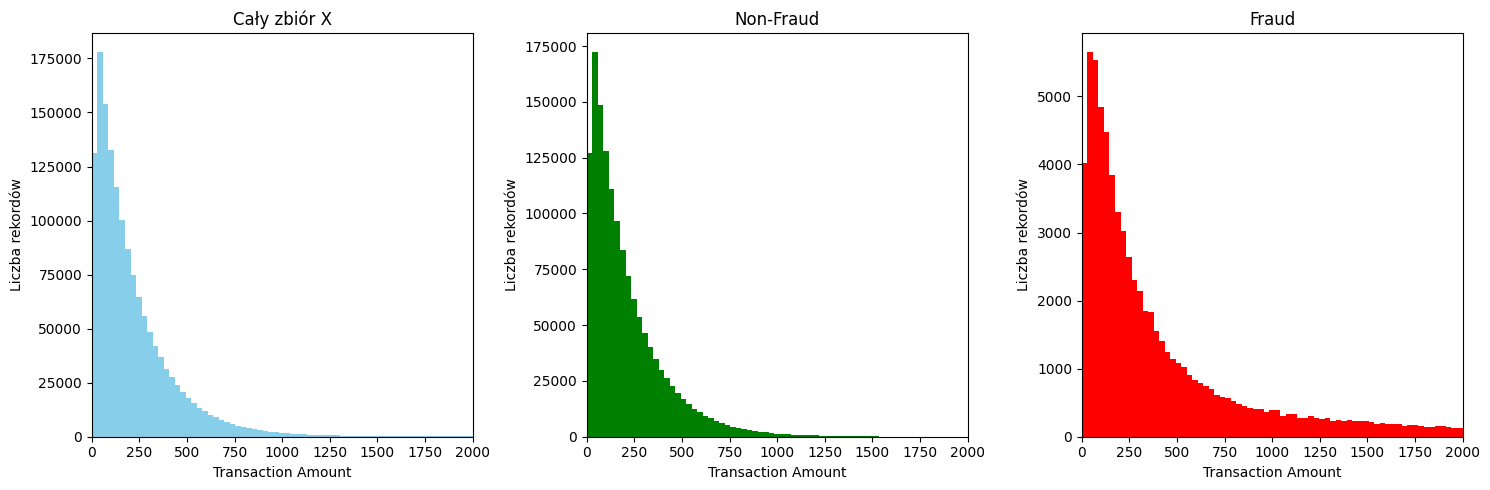

In [294]:
# Rozkład 'Transaction Amount'
plot_distribution_histograms(X, y, variable='Transaction Amount', num_bins=70, xlim_range=(0, 2000), save_path='transaction_amount_hist_different_scales.png')

Oszustwa mogą być związane z wyższymi kwotami transakcji co widać na rozkładzie na trzecim wykresie.

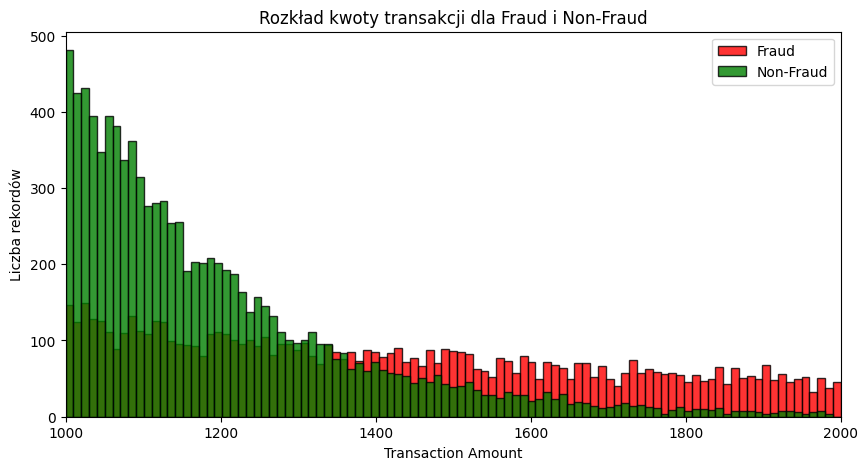

In [295]:
bins = np.linspace(1000, 2000, 100)
plt.figure(figsize=(10, 5))

plt.hist(X[y == 1]['Transaction Amount'], bins=bins, alpha=0.8, color='red', label='Fraud', edgecolor='black')

plt.hist(X[y == 0]['Transaction Amount'], bins=bins, alpha=0.8, color='green', label='Non-Fraud', edgecolor='black')

plt.xlim(1000, 2000)
plt.xlabel('Transaction Amount')
plt.ylabel('Liczba rekordów')
plt.title('Rozkład kwoty transakcji dla Fraud i Non-Fraud')
plt.legend()

plt.show()

Przybliżając ogon wykresu jeszcze bardziej widać te różnice.

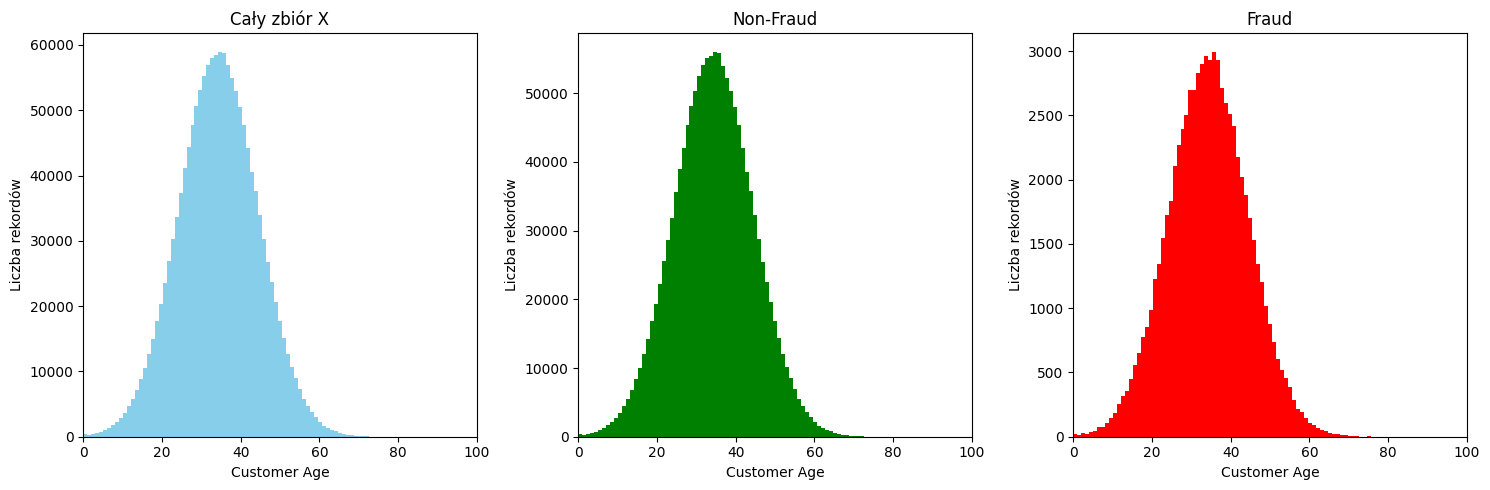

In [296]:
# Rozkład 'Customer Age'
plot_distribution_histograms(X, y, variable='Customer Age', num_bins=100, xlim_range=(0, 100), save_path='customer_age_hist_different_scales.png')

Widać, że rozkład wieku jest podobny niezależnie od tego czy było uszustwo.

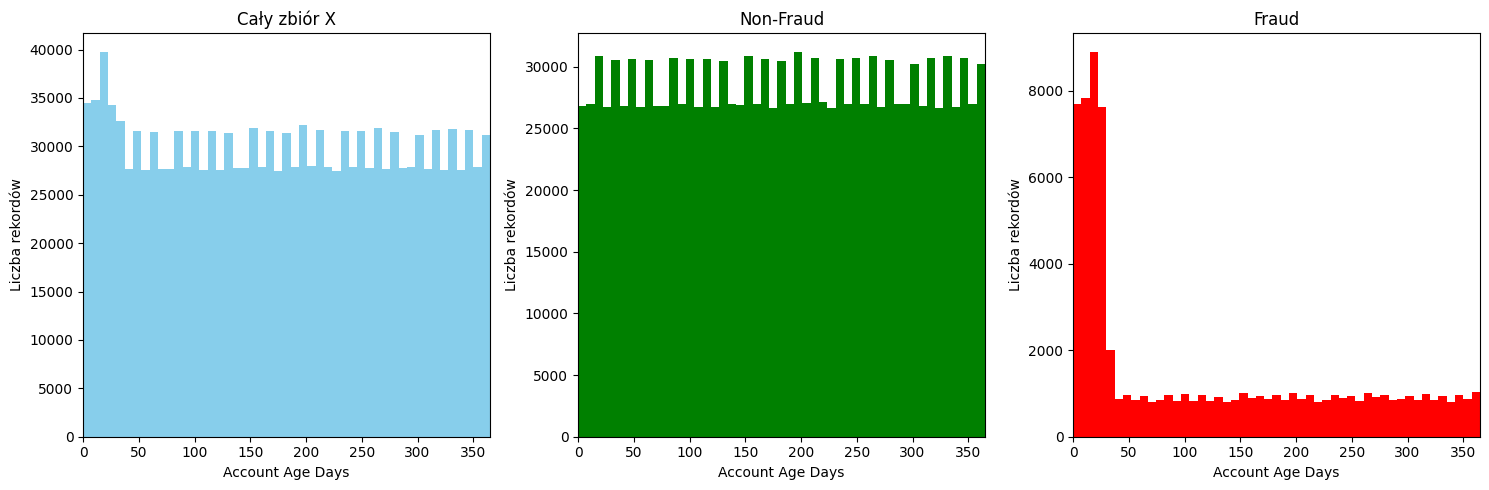

In [297]:
# Rozkład 'Account Age Days'
plot_distribution_histograms(X, y, variable='Account Age Days', num_bins=50, xlim_range=(0, 365), save_path='account_age_days_hist_different_scales.png')

Wiek konta w przypadku oszustw jest zauważalnie niższy niż w przypadku uczciwej transakcji. 'Account Age' wydaje się być istotną zmienną.

### Analiza rozkładu pozostałych zmiennych

In [298]:
def plot_unique_value_bars(X, y, variable, save_path='unique_values_distribution.png'):
   
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    counts_all = X[variable].value_counts().sort_index()
    counts_non_fraud = X[y == 0][variable].value_counts().sort_index()
    counts_fraud = X[y == 1][variable].value_counts().sort_index()

    axes[0].bar(counts_all.index, counts_all.values, color='skyblue')
    axes[0].set_title('Cały zbiór X')
    axes[0].set_ylabel('Liczba rekordów')

    axes[1].bar(counts_non_fraud.index, counts_non_fraud.values, color='green')
    axes[1].set_title('Non-Fraud')
    axes[1].set_ylabel('Liczba rekordów')

    axes[2].bar(counts_fraud.index, counts_fraud.values, color='red')
    axes[2].set_title('Fraud')
    axes[2].set_ylabel('Liczba rekordów')

    for ax in axes:
        ax.set_xlabel(variable)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

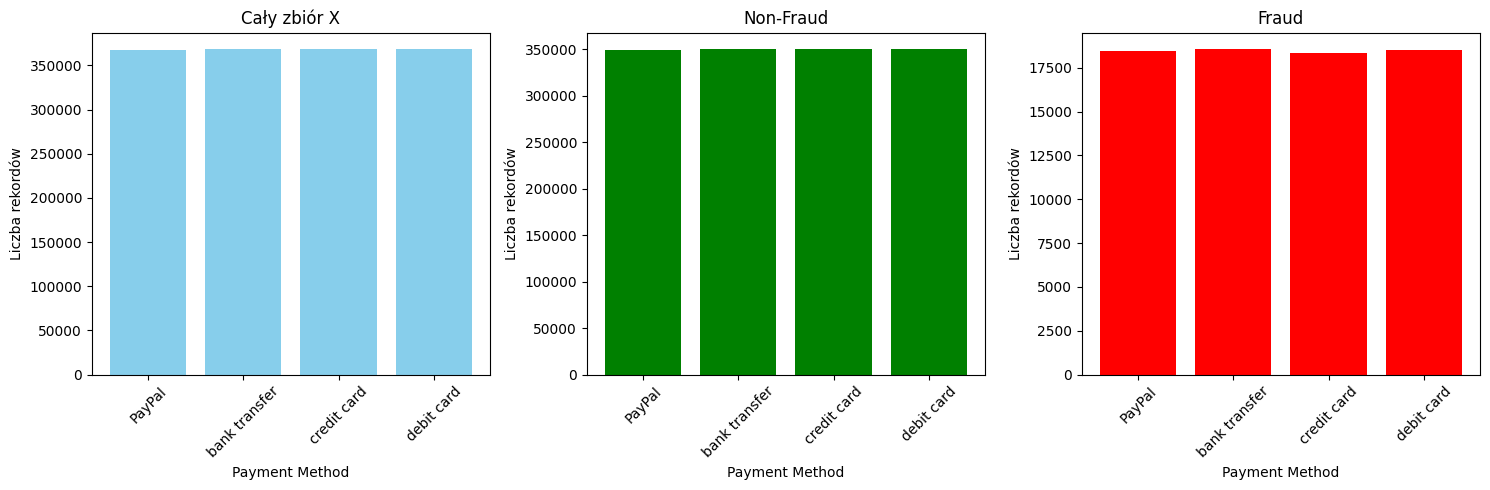

In [299]:
# Rozkład 'Payment Method'
plot_unique_value_bars(X, y, variable='Payment Method', save_path='payment_method_unique_dist.png')

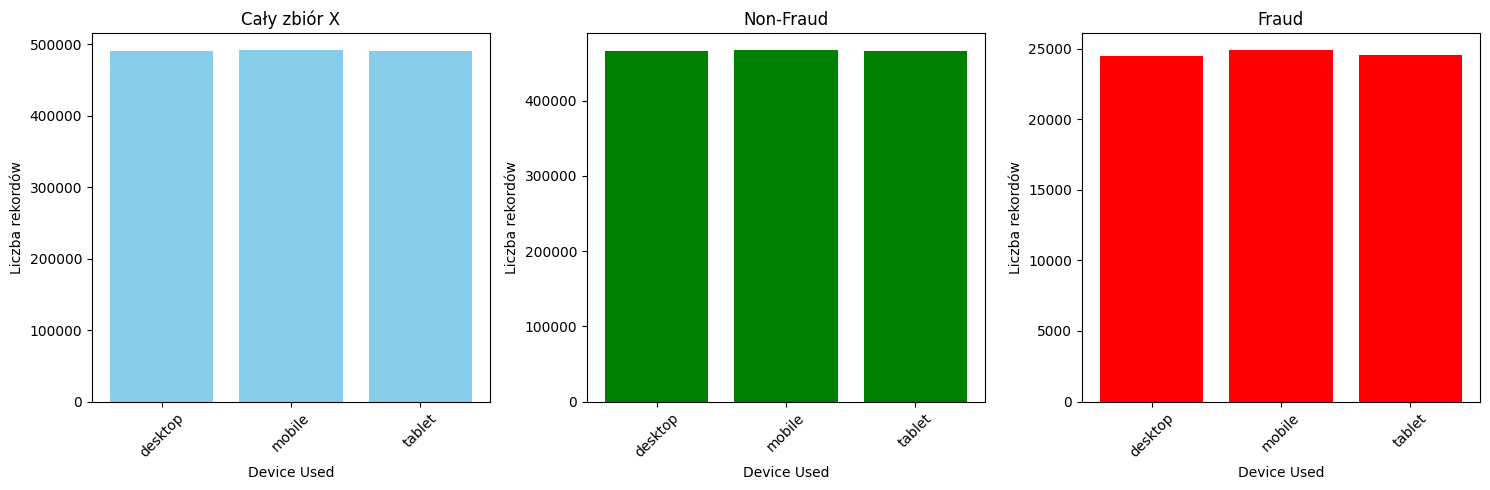

In [300]:
# Rozkład 'Device Used'
plot_unique_value_bars(X, y, variable='Device Used', save_path='device_used_unique_dist.png')

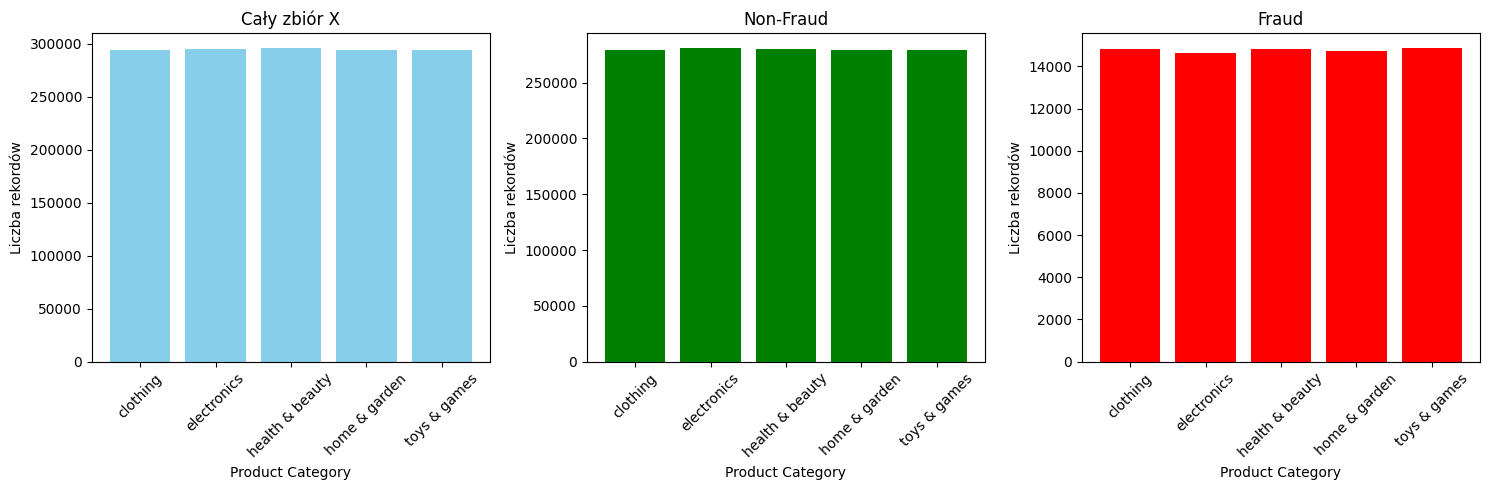

In [301]:
# Rozkład 'Product Category'
plot_unique_value_bars(X, y, variable='Product Category', save_path='product_category_unique_dist.png')

Widzimy, że metody płatności, używane urządzenia jak i kategorie produktów rozkładają się równomiernie.

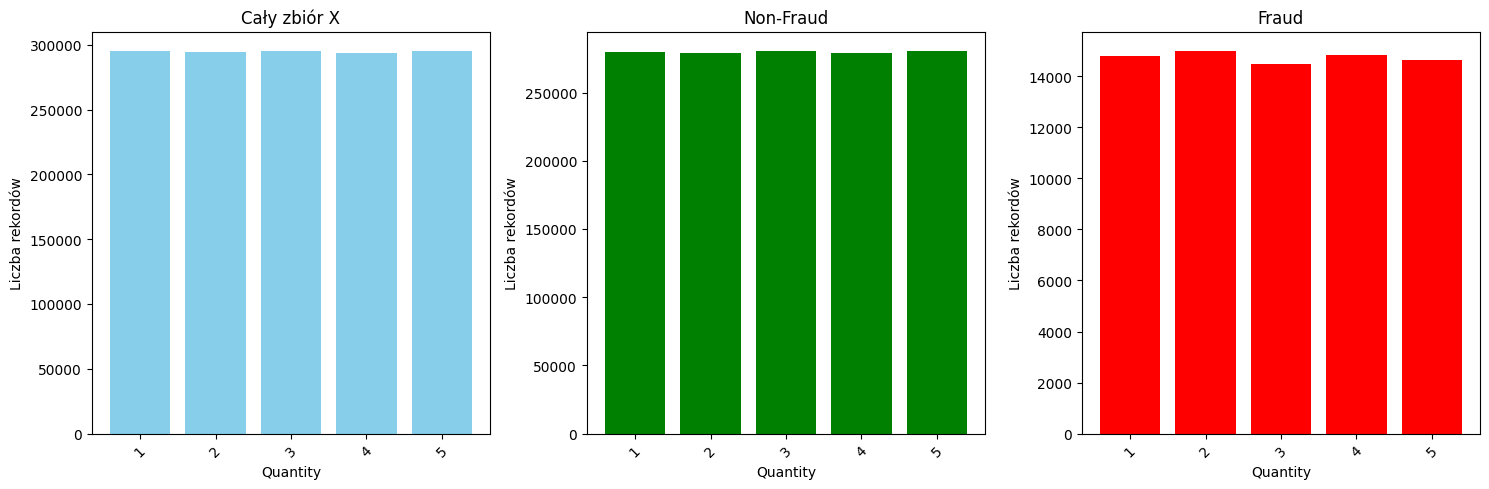

In [302]:
# Rozkład 'Quantity'
plot_unique_value_bars(X, y, variable='Quantity', save_path='quantity_unique_dist.png')

Jest zauważalny lekki spadek oszustw przy ilości towarów równej 3, aczkolwiek nie widac go przy 4 i 5 towarach, dlatego znaczenie 'Quantity' jest raczej pomijalne.

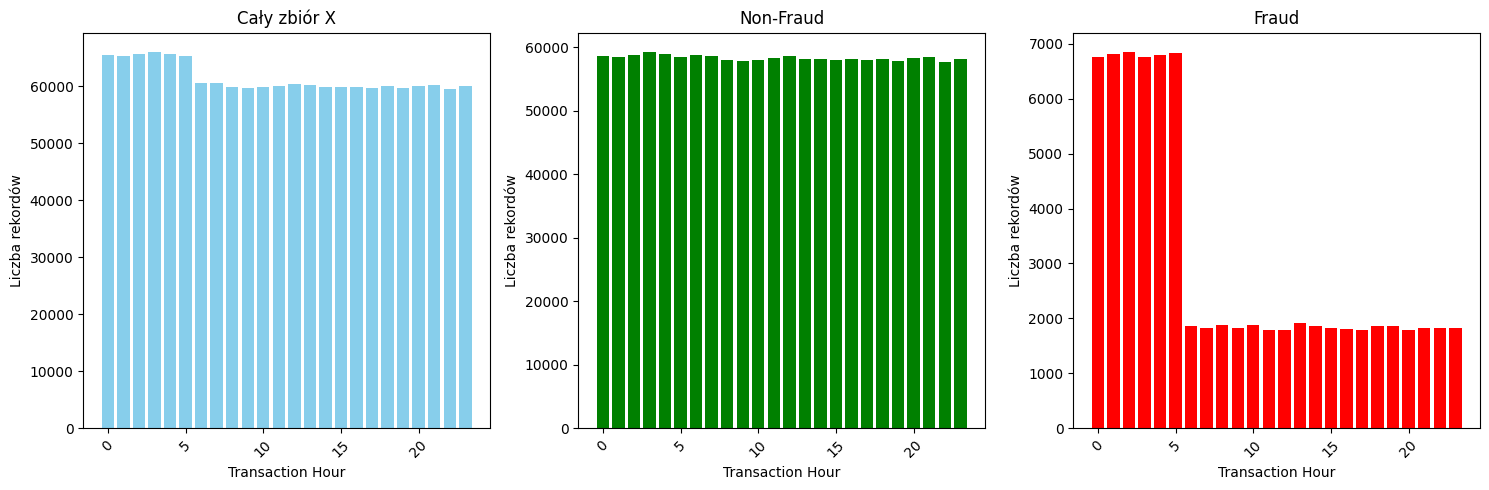

In [303]:
# Rozkład 'Transaction Hour'
plot_unique_value_bars(X, y, variable='Transaction Hour', save_path='transaction_hour_unique_dist.png')

Jest zauważalny spadek ilości oszustw w godzinach dziennych. Zmienna 'Transaction Hour' wydaje się być istotna.

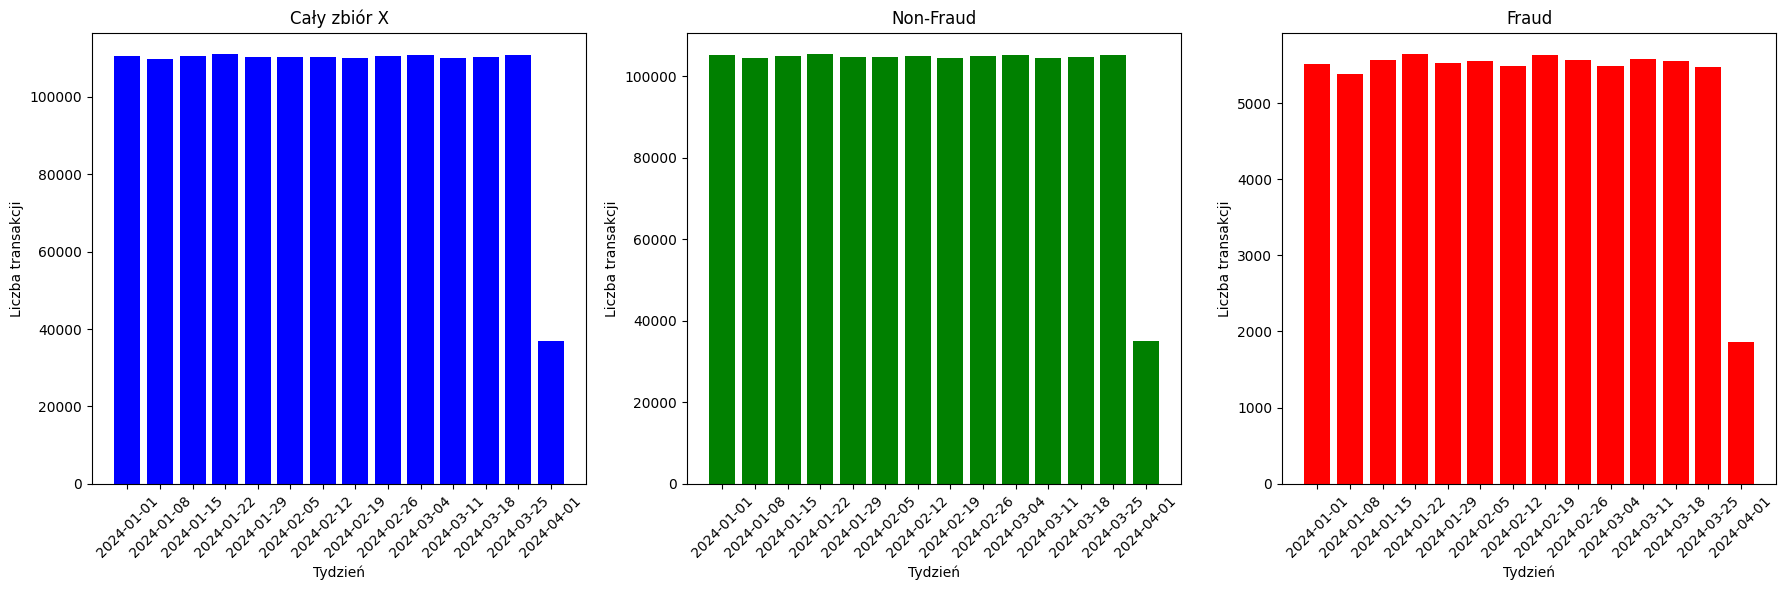

In [304]:
# Grupowanie tygodniowe
weekly_counts = X.groupby(pd.to_datetime(X['Transaction Date']).dt.to_period('W')).size()
weekly_counts_fraud = X.loc[y == 1].groupby(pd.to_datetime(X.loc[y == 1, 'Transaction Date']).dt.to_period('W')).size()
weekly_counts_non_fraud = X.loc[y == 0].groupby(pd.to_datetime(X.loc[y == 0, 'Transaction Date']).dt.to_period('W')).size()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, data, title, color in zip(axes, [weekly_counts, weekly_counts_non_fraud, weekly_counts_fraud], 
                                  ['Cały zbiór X', 'Non-Fraud', 'Fraud'],
                                  ['blue', 'green', 'red']):
    ax.bar(data.index.astype(str), data, color=color)
    ax.set_xlabel("Tydzień")
    ax.set_ylabel("Liczba transakcji")
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(range(len(data.index)))
    ax.set_xticklabels([w.start_time.strftime('%Y-%m-%d') for w in data.index], rotation=45)
    ax.set_title(title)

plt.tight_layout()
plt.show()

Widzimy, że data nie ma wpływu na to czy było oszustwo. Ważna jest dla nas godzina transakcji więc zajmiemy się analizą tylko "Transaction Hour".

### Identyfikacja brakujących danych, wartości odstających oraz wstępne wykrywanie anomalii.

#### Brakujace dane:
Na całym zbiorze nie ma żadnych brakujących danych.

In [305]:
print(df1.isnull().sum().sum() == 0)

True


#### Wartości odstające:

Przeanalizujemy wartości odstajace tylko na kolumnach: 'Transaction Amount', 'Customer Age', 'Account Age Days', 'Transaction Hour', ponieważ z wykresów rozkładu widać, że pozostałe kolumny nie mają wartości odstających.

In [306]:
def plot_age_boxplots(X_train, y_train, column_name):
    train_data = pd.concat([X_train, y_train], axis=1)
    target_col = y_train.name

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.boxplot(y=train_data[column_name], ax=axes[0])
    axes[0].set_title(f'{column_name} (All)')

    sns.boxplot(y=train_data[train_data[target_col] == 0][column_name], ax=axes[1])
    axes[1].set_title(f'{column_name} ({target_col} = 0)')

    sns.boxplot(y=train_data[train_data[target_col] == 1][column_name], ax=axes[2])
    axes[2].set_title(f'{column_name} ({target_col} = 1)')

    plt.tight_layout()
    plt.show()

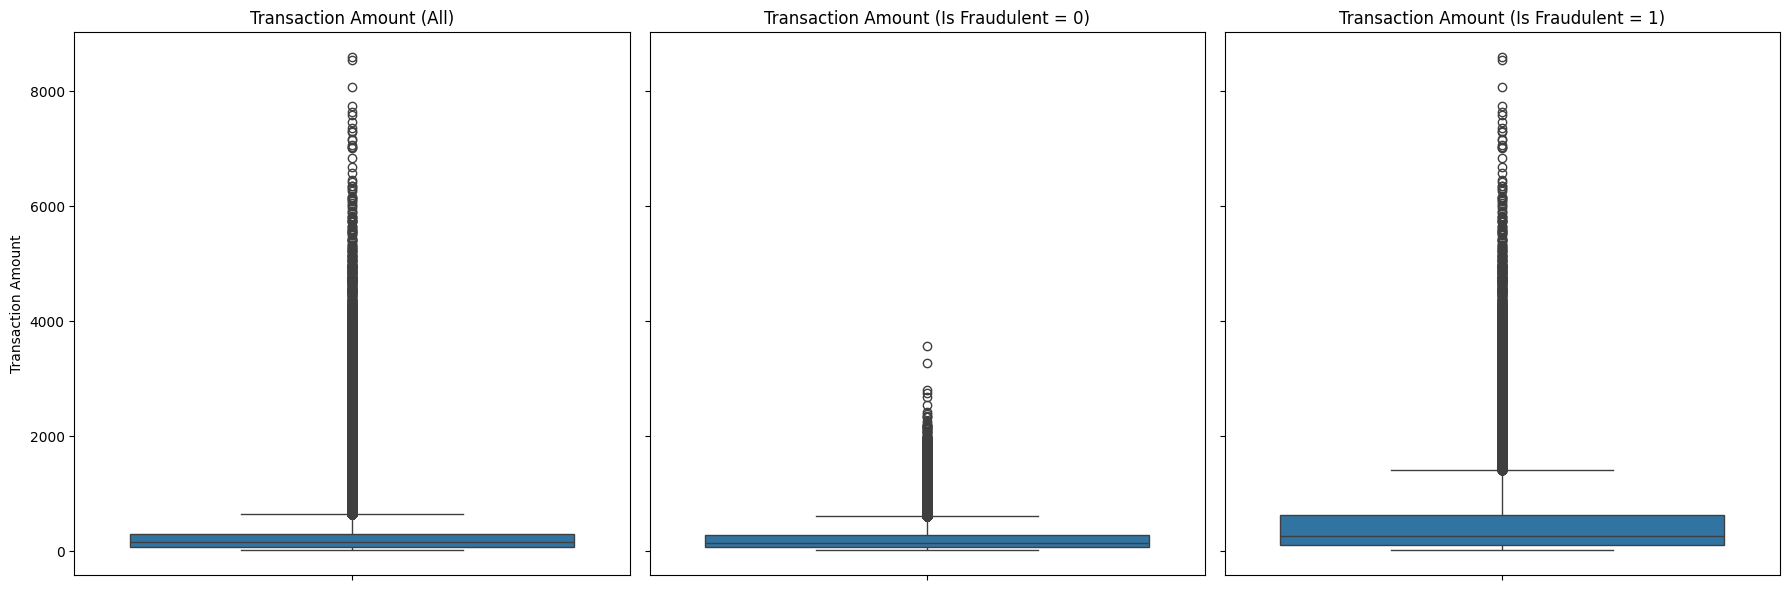

count    721746.000000
mean        226.764298
std         270.403836
min          10.000000
25%          68.700000
50%         151.750000
75%         295.600000
max        8594.900000
Name: Transaction Amount, dtype: float64

In [307]:
plot_age_boxplots(X_train, y_train, 'Transaction Amount')
X_train['Transaction Amount'].describe()

Nie ma uczciwych transakcji powyżej kwoty 4000. Zapewne od pewnej kwoty wszystkie transakcje powinny być oznaczane jako potencjalne oszustwo, można rozważyć ograniczenie górne kwoty transakcji.

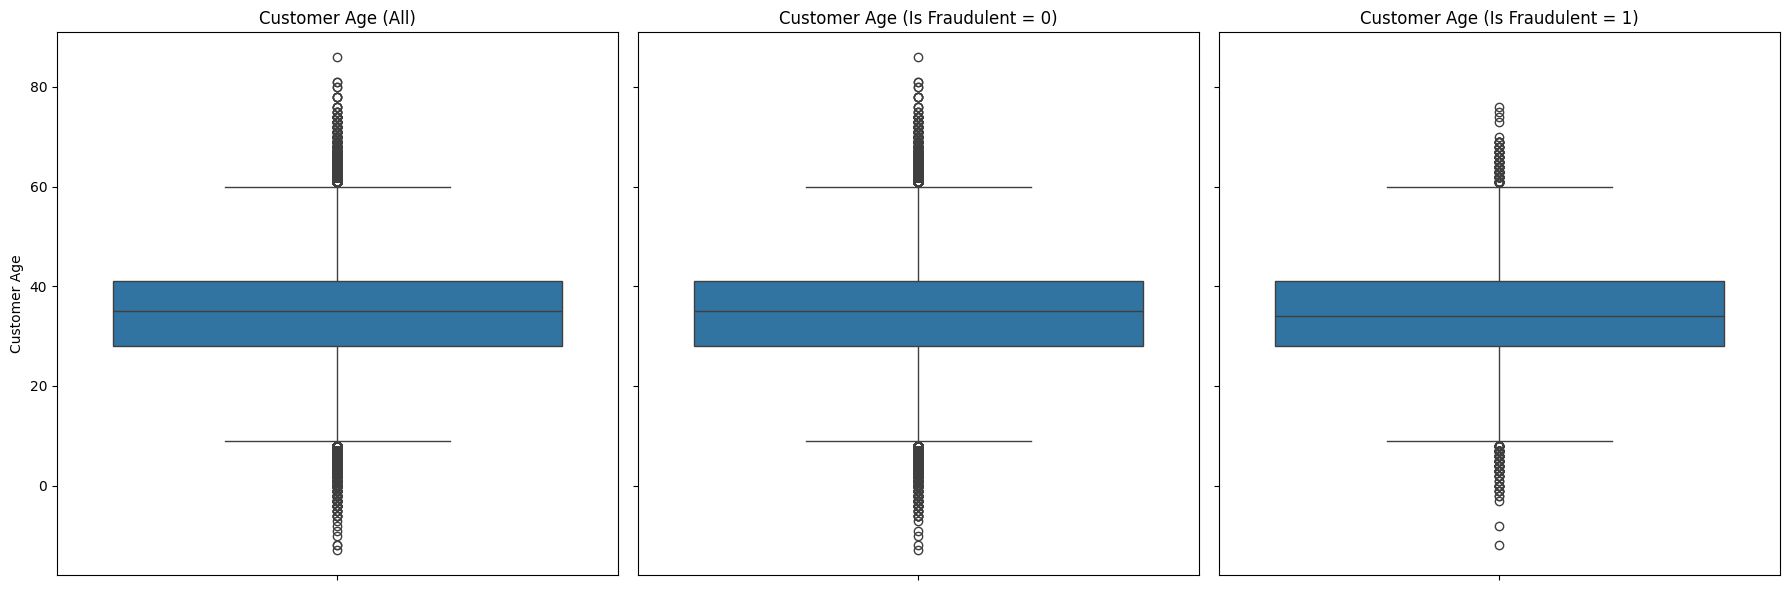

count    721746.000000
mean         34.512901
std          10.000521
min         -13.000000
25%          28.000000
50%          35.000000
75%          41.000000
max          86.000000
Name: Customer Age, dtype: float64

In [308]:
plot_age_boxplots(X_train, y_train, 'Customer Age')
X_train['Customer Age'].describe()

Należy usunąć wiek poniżej 0, a być może nawet ograniczyć wiek do przynajmniej 16 lat i rozważyć zastąpienie wszystkich niższych wartości przez 16.

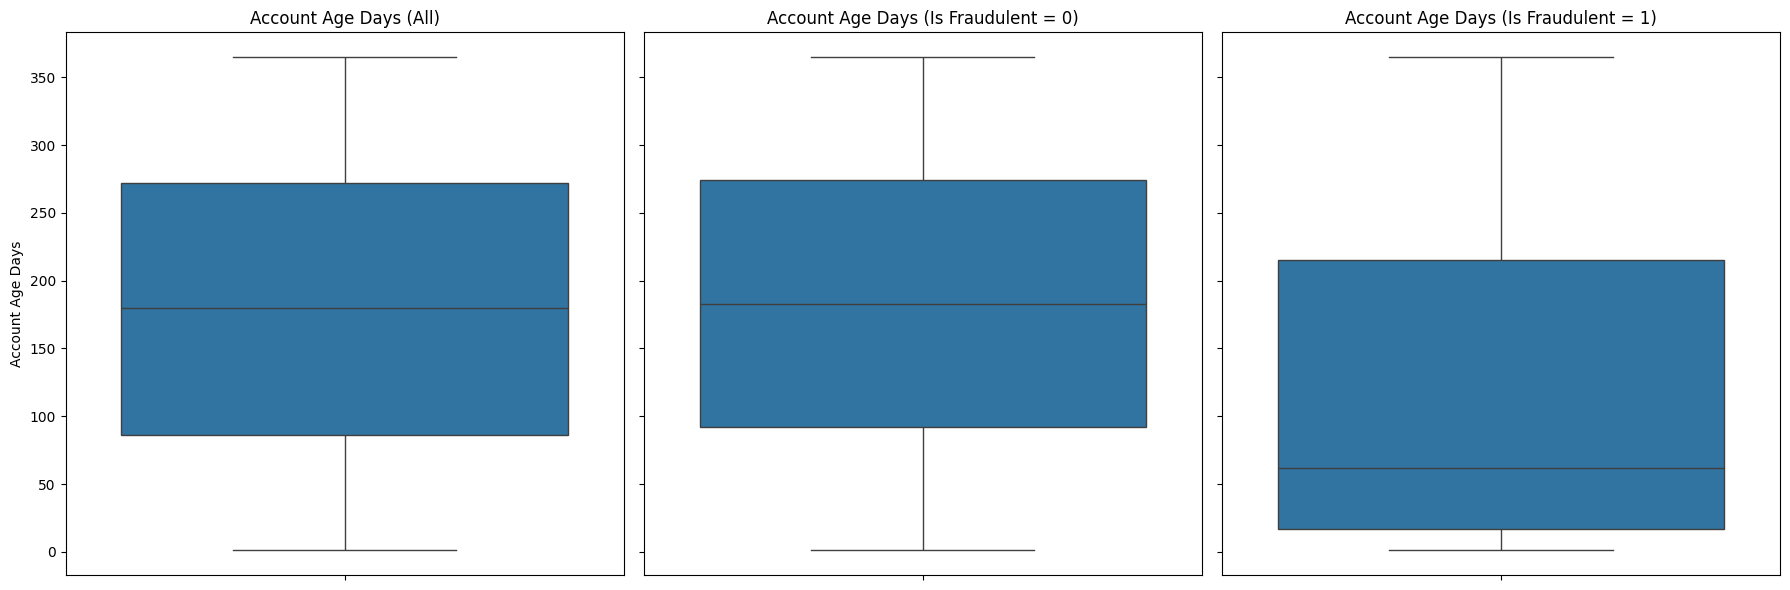

count    721746.000000
mean        179.730932
std         106.896129
min           1.000000
25%          86.000000
50%         180.000000
75%         272.000000
max         365.000000
Name: Account Age Days, dtype: float64

In [309]:
plot_age_boxplots(X_train, y_train, 'Account Age Days')
X_train['Account Age Days'].describe()

Mediana wieku konta w przypadku oszustw jest zauważalnie niższa niż, w przypadku uczciwej transakcji. 'Account Age' wydaje się być istotną zmienną.

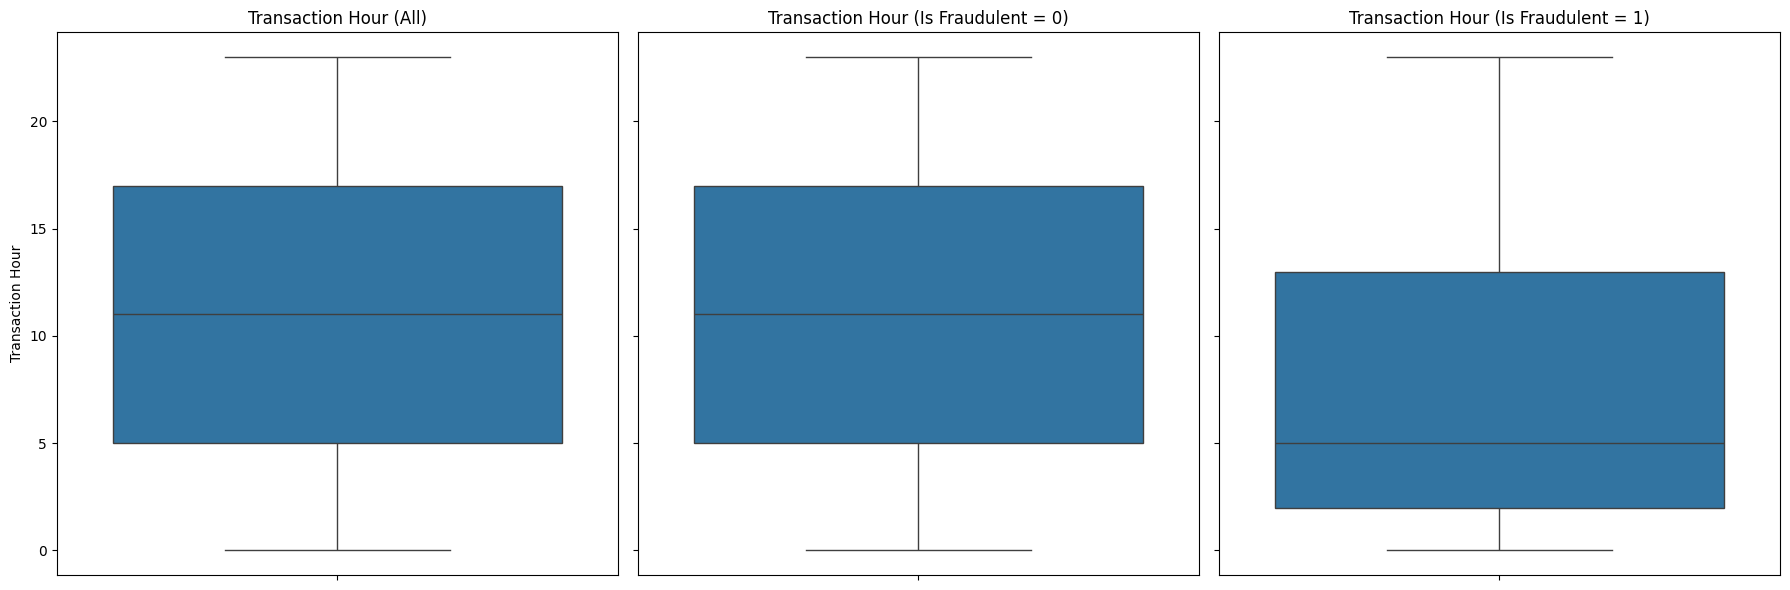

In [310]:
plot_age_boxplots(X_train, y_train, 'Transaction Hour')

W przypadku oszustw mediana godziny zawarcia transakcji znajduje się w godzinach wczesno porannych, w przeciwnych przypadkach jest to koło południa. Było to widoczne równiez na histogramie. Transaction Hour wydaje się być istotną zmienną.

## Wstępne przetwarzanie danych

In [311]:
# Ze względu na brak brakujacych danych, skoncentrujemy sie na czyszczeniu danych odstajacych.
def clean_data(df):
    max_amount = 4000
    min_age = 16

    df.loc[df['Transaction Amount'] > max_amount, 'Transaction Amount'] = max_amount
    df.loc[df['Customer Age'] < min_age, 'Customer Age'] = min_age
    return df

In [312]:
# Czyszczenie danych dla wszystkich zbiorów
X_train_clean = clean_data(X_train)
X_valid_clean = clean_data(X_valid)

## Balansowanie danych

Usuniemy kolumnę 'Transaction Date' (wystarczy nam 'Transaction Hour') oraz 'Customer Location', ponieważ wykorzystamy 'Shipping Address' i 'Billing Address', żeby sprawdzić czy adres jest zgodny.

In [313]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# --- Custom Transformation Functions ---

# 1. Drop unnecessary columns
def drop_columns(X):
    return X.drop(columns=['Transaction Date', 'Customer Location'])

# 2. One-Hot Encoding with pandas.get_dummies
def one_hot_encoding(X):
    X_out = X.copy()
    X_out = pd.get_dummies(X_out, columns=['Payment Method'], prefix='payment')
    X_out = pd.get_dummies(X_out, columns=['Product Category'], prefix='product')
    X_out = pd.get_dummies(X_out, columns=['Device Used'], prefix='device')
    return X_out

# 3. Cyclic transformation of Transaction Hour
def cyclic_hour_transform(X):
    X_out = X.copy()
    X_out['sin_hour'] = np.sin(2 * np.pi * X['Transaction Hour'] / 24)
    X_out['cos_hour'] = np.cos(2 * np.pi * X['Transaction Hour'] / 24)
    return X_out

# 4. Compare Shipping Address and Billing Address
def shipping_billing_comparison(X):
    X_out = X.copy()
    
    def address_similarity(shipping, billing):
        # If either address is missing, return 0
        if pd.isna(shipping) or pd.isna(billing):
            return 0.0
            
        # If addresses are identical, return 1
        if shipping == billing:
            return 1.0
            
        # Convert to strings and normalize
        shipping = str(shipping).lower().strip()
        billing = str(billing).lower().strip()
        
        # Split into components
        shipping_parts = set(shipping.split())
        billing_parts = set(billing.split())
        
        # Calculate intersection and union
        common_parts = shipping_parts.intersection(billing_parts)
        all_parts = shipping_parts.union(billing_parts)
        
        # If no parts exist, return 0
        if not all_parts:
            return 0.0
            
        # Calculate similarity ratio
        similarity = len(common_parts) / len(all_parts)
        
        # Boost similarity if key numbers match (extract first sequence of digits)
        shipping_nums = ''.join(filter(str.isdigit, shipping[:10]))
        billing_nums = ''.join(filter(str.isdigit, billing[:10]))
        if shipping_nums and billing_nums and shipping_nums == billing_nums:
            similarity = min(1.0, similarity + 0.3)  # Boost by 0.3, capped at 1.0
            
        return similarity

    X_out['addressSimilarity'] = X.apply(
        lambda row: address_similarity(row['Shipping Address'], row['Billing Address']), 
        axis=1
    )
    
    return X_out.drop(columns=['Shipping Address', 'Billing Address'])

# 5. Split IP Address into octets
def ip_to_octets(X):
    X_out = X.copy()
    X_out[['octet1', 'octet2', 'octet3', 'octet4']] = X['IP Address'].str.split('.', expand=True).astype(int)
    return X_out.drop(columns=['IP Address'])

# --- Define the Pipeline ---
pipeline = Pipeline(steps=[
    # Step 1: Drop initial columns
    ('drop_initial_columns', FunctionTransformer(drop_columns)),
    
    # Step 2: One-Hot Encoding with pandas.get_dummies
    ('one_hot_encoding', FunctionTransformer(one_hot_encoding)),
    
    # Step 3: Cyclic transformation of Transaction Hour
    ('cyclic_hour', FunctionTransformer(cyclic_hour_transform)),
    
    # Step 4: Compare Shipping and Billing Address
    ('shipping_billing', FunctionTransformer(shipping_billing_comparison)),
    
    # Step 5: Split IP Address into octets
    ('ip_octets', FunctionTransformer(ip_to_octets))
])

In [314]:
# --- Wykonanie Pipeline ---
X_encoded_train = pipeline.fit_transform(X_train_clean.copy())
X_valid_encoded = pipeline.fit_transform(X_valid_clean.copy())


In [315]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
 
# 1. Oversampling (SMOTE) to 50/50

smote = SMOTE(sampling_strategy=1.0, random_state=777)

X_train_smote, y_train_smote = smote.fit_resample(X_encoded_train, y_train)
 
# 2. Oversampling (RandomOverSampler) to 50/50

ros = RandomOverSampler(sampling_strategy=1.0, random_state=777)

X_train_ros, y_train_ros = ros.fit_resample(X_encoded_train, y_train)
 
# Przykładowe sprawdzenie proporcji klas po zbalansowaniu:

print("Proporcje klas przed balansowaniem:", y_train.value_counts(normalize=True))

print("Proporcje klas po SMOTE:", pd.Series(y_train_smote).value_counts(normalize=True))

print("Proporcje klas po RandomOverSampler:", pd.Series(y_train_ros).value_counts(normalize=True))

Proporcje klas przed balansowaniem: Is Fraudulent
0    0.94987
1    0.05013
Name: proportion, dtype: float64
Proporcje klas po SMOTE: Is Fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64
Proporcje klas po RandomOverSampler: Is Fraudulent
0    0.5
1    0.5
Name: proportion, dtype: float64


In [316]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def compare_approaches(X_train, y_train, X_valid, y_valid, feature_names=None, withCalibration=False):
    """
    Compares six different approaches for handling imbalanced data and classification:
    1. SMOTE + Logistic Regression
    2. Random Undersampler + Logistic Regression
    3. SMOTE + Decision Tree Classifier
    4. Random Undersampler + Decision Tree Classifier
    
    Parameters:
    - X_train: Training feature set (pandas DataFrame or numpy array)
    - y_train: Training labels (pandas Series or numpy array)
    - X_valid: Validation feature set (pandas DataFrame or numpy array)
    - y_valid: Validation labels (pandas Series or numpy array)
    - feature_names: List of feature names (optional, required for feature importance)
    - withCalibration: Boolean, whether to apply calibration to classifiers (default: False)
    
    Returns:
    - results_df: A DataFrame containing performance metrics for each approach
    """
    
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist() if feature_names is None else feature_names
        X_train = X_train.values
        X_valid = X_valid.values

    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

    sampling_methods = {
        'SMOTE': SMOTE(sampling_strategy=0.25, random_state=777),
        # 'Random Oversampler': RandomOverSampler(sampling_strategy=1.0, random_state=777),
        # 'Random Undersampler': RandomUnderSampler(sampling_strategy=1.0, random_state=777)
    }

    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=4)
    }

    results = []
    balanced_data = {}

    for sampler_name, sampler in sampling_methods.items():
        X_train_bal, y_train_bal = sampler.fit_resample(X_train, y_train)
        balanced_data[sampler_name] = (X_train_bal, y_train_bal)

    for sampler_name, (X_train_bal, y_train_bal) in balanced_data.items():
        for clf_name, clf in classifiers.items():
            clf.fit(X_train_bal, y_train_bal)

            # Calibration setup if withCalibration is True
            if withCalibration:
                kf = KFold(n_splits=5, shuffle=True, random_state=42)
                calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=kf)
                calibrated_clf.fit(X_train_bal, y_train_bal)

            for dataset, X, y, label in [('Train', X_train_bal, y_train_bal, 'Training'), ('Valid', X_valid, y_valid, 'Validation')]:
                y_pred = clf.predict(X)
                y_pred_proba = clf.predict_proba(X)[:, 1]
                report = classification_report(y, y_pred, output_dict=True)
                auc_roc = roc_auc_score(y, y_pred_proba)

                # Additional metrics and predictions if calibration is enabled
                if withCalibration:
                    y_pred_calibrated = calibrated_clf.predict(X)
                    y_pred_proba_calibrated = calibrated_clf.predict_proba(X)[:, 1]
                    report_calibrated = classification_report(y, y_pred_calibrated, output_dict=True)
                    auc_roc_calibrated = roc_auc_score(y, y_pred_proba_calibrated)
                    brier_before = brier_score_loss(y, y_pred_proba)
                    brier_sigmoid = brier_score_loss(y, y_pred_proba_calibrated)

                if clf_name == 'Logistic Regression':
                    importance = np.abs(clf.coef_[0])
                    importance_reason = "Absolute coefficient values (larger = more impact on prediction)"
                else:
                    importance = clf.feature_importances_
                    importance_reason = "Feature importance scores (higher = more influential in splits)"

                n_features = min(7, len(feature_names))
                top_indices = np.argsort(importance)[::-1][:n_features]
                top_features = [(feature_names[i], importance[i]) for i in top_indices]

                result_dict = {
                    'Sampler': sampler_name,
                    'Classifier': clf_name,
                    'Dataset': label,
                    'Precision_0': report['0']['precision'],
                    'Recall_0': report['0']['recall'],
                    'F1_0': report['0']['f1-score'],
                    'Precision_1': report['1']['precision'],
                    'Recall_1': report['1']['recall'],
                    'F1_1': report['1']['f1-score'],
                    'Accuracy': report['accuracy'],
                    'AUC-ROC': auc_roc,
                    'Top_Features': str(top_features)
                }

                if withCalibration:
                    result_dict.update({
                        'Precision_0 (Calibrated)': report_calibrated['0']['precision'],
                        'Recall_0 (Calibrated)': report_calibrated['0']['recall'],
                        'F1_0 (Calibrated)': report_calibrated['0']['f1-score'],
                        'Precision_1 (Calibrated)': report_calibrated['1']['precision'],
                        'Recall_1 (Calibrated)': report_calibrated['1']['recall'],
                        'F1_1 (Calibrated)': report_calibrated['1']['f1-score'],
                        'Accuracy (Calibrated)': report_calibrated['accuracy'],
                        'AUC-ROC (Calibrated)': auc_roc_calibrated,
                        'Brier Before': brier_before,
                        'Brier Sigmoid': brier_sigmoid
                    })

                results.append(result_dict)

                print(f"\n--- {sampler_name} + {clf_name} ({label}) ---")
                print("Before Calibration:" if withCalibration else "Results:")
                print(classification_report(y, y_pred))
                print(f"AUC-ROC Score: {auc_roc:.4f}")
                if withCalibration:
                    print(f"Brier Score Loss Before Calibration: {brier_before:.4f}")
                    print("\nAfter Calibration (Sigmoid):")
                    print(classification_report(y, y_pred_calibrated))
                    print(f"AUC-ROC Score (After Calibration): {auc_roc_calibrated:.4f}")
                    print(f"Brier Score Loss After Calibration (Sigmoid): {brier_sigmoid:.4f}")

                print(f"\nTop {n_features} Most Significant Features (out of {len(feature_names)}):")
                print(f"Importance metric: {importance_reason}")
                for feature, score in top_features:
                    print(f"- {feature}: {score:.4f}")

                fpr, tpr, _ = roc_curve(y, y_pred_proba)
                plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_roc:.4f})')
                if withCalibration:
                    fpr_cal, tpr_cal, _ = roc_curve(y, y_pred_proba_calibrated)
                    plt.plot(fpr_cal, tpr_cal, label=f'{label} (AUC (calibrated) = {auc_roc_calibrated:.4f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve: {sampler_name} + {clf_name}')
            plt.legend(loc='best')
            plt.show()

    results_df = pd.DataFrame(results)
    return results_df

In [317]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# --- Custom Transformation Function ---

# Function to classify whether an IP address belongs to a local or public network
def classify_network_transformer(X):
    X_out = X.copy()
    
    # Inner function to determine local vs public network based on octets
    def classify_network(row):
        octet1 = row['octet1']
        octet2 = row['octet2']
        if octet1 == 10:  # Class A: 10.0.0.0 - 10.255.255.255
            return 1  # Local
        elif octet1 == 172 and (16 <= octet2 <= 31):  # Class B: 172.16.0.0 - 172.31.255.255
            return 1  # Local
        elif octet1 == 192 and octet2 == 168:  # Class C: 192.168.0.0 - 192.168.255.255
            return 1  # Local
        else:
            return 0  # Public
    
    # Apply the classification to each row and add as a new column
    X_out['isLocalNetwork'] = X_out.apply(classify_network, axis=1)
    return X_out


--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    685565
           1       0.72      0.27      0.39    171391

    accuracy                           0.83    856956
   macro avg       0.78      0.62      0.65    856956
weighted avg       0.82      0.83      0.80    856956

AUC-ROC Score: 0.7831

Top 7 Most Significant Features (out of 25):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- cos_hour: 0.4320
- device_desktop: 0.1051
- device_tablet: 0.1002
- device_mobile: 0.0977
- payment_credit card: 0.0808
- payment_PayPal: 0.0789
- payment_debit card: 0.0762

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    293814
           1       0.36      0.28      0.32     15506

    accuracy                           0.94    309320
   macro av

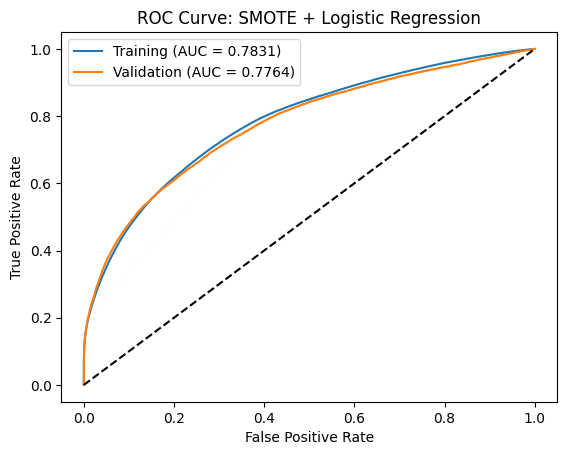


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    685565
           1       0.79      0.40      0.53    171391

    accuracy                           0.86    856956
   macro avg       0.83      0.69      0.72    856956
weighted avg       0.85      0.86      0.84    856956

AUC-ROC Score: 0.8123

Top 7 Most Significant Features (out of 25):
Importance metric: Feature importance scores (higher = more influential in splits)
- Account Age Days: 0.5218
- Transaction Amount: 0.2723
- Transaction Hour: 0.1536
- cos_hour: 0.0315
- sin_hour: 0.0208
- product_electronics: 0.0000
- Quantity: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.42      0.37      0.40     15506

    accuracy                           0.94    309320
   macro avg       0.70      0

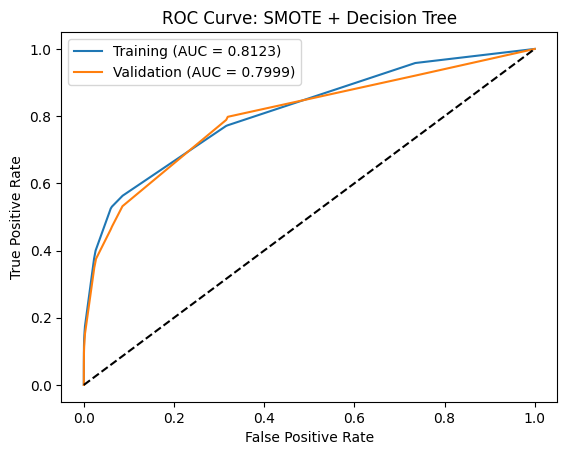

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.841973,0.974385,0.903353,0.723784,0.268486,0.391679,0.833205,0.783137,"[('cos_hour', np.float64(0.4320140140465478)),..."
1,SMOTE,Logistic Regression,Validation,0.962495,0.973990,0.968209,0.363007,0.280859,0.316693,0.939244,0.776358,"[('cos_hour', np.float64(0.4320140140465478)),..."
2,SMOTE,Decision Tree,Training,0.866650,0.973632,0.917032,0.791651,0.400756,0.532132,0.859057,0.812282,"[('Account Age Days', np.float64(0.52177279496..."
3,SMOTE,Decision Tree,Validation,0.967197,0.973225,0.970201,0.424717,0.374565,0.398067,0.943214,0.799896,"[('Account Age Days', np.float64(0.52177279496..."


In [318]:
# --- Execute the Pipeline ---
# Assuming X_encoded_train is the output from the previous pipeline
# --- Define the Pipeline ---
pipeline_1 = Pipeline(steps=[
    # Step 1: Add 'isLocalNetwork' column based on IP octet classification
    ('classify_network', FunctionTransformer(classify_network_transformer))
])
X_encoded_train_1 = pipeline_1.fit_transform(X_encoded_train.copy())
X_encoded_valid_1 = pipeline_1.fit_transform(X_valid_encoded.copy())
compare_approaches(X_encoded_train_1, y_train, X_encoded_valid_1, y_valid)


--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90    685565
           1       0.72      0.27      0.39    171391

    accuracy                           0.83    856956
   macro avg       0.78      0.62      0.65    856956
weighted avg       0.82      0.83      0.80    856956

AUC-ROC Score: 0.7831

Top 7 Most Significant Features (out of 25):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- cos_hour: 0.4320
- device_desktop: 0.1051
- device_tablet: 0.1002
- device_mobile: 0.0977
- payment_credit card: 0.0808
- payment_PayPal: 0.0789
- payment_debit card: 0.0762

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    293814
           1       0.36      0.28      0.32     15506

    accuracy                           0.94    309320
   macro av

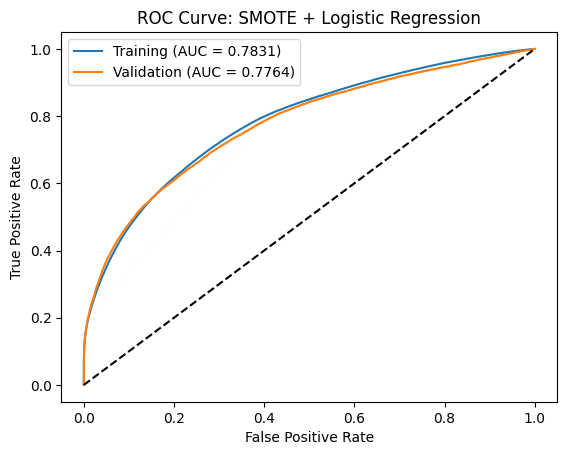


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    685565
           1       0.79      0.40      0.53    171391

    accuracy                           0.86    856956
   macro avg       0.83      0.69      0.72    856956
weighted avg       0.85      0.86      0.84    856956

AUC-ROC Score: 0.8123

Top 7 Most Significant Features (out of 25):
Importance metric: Feature importance scores (higher = more influential in splits)
- Account Age Days: 0.5218
- Transaction Amount: 0.2723
- Transaction Hour: 0.1536
- cos_hour: 0.0315
- sin_hour: 0.0208
- product_electronics: 0.0000
- Quantity: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.42      0.37      0.40     15506

    accuracy                           0.94    309320
   macro avg       0.70      0

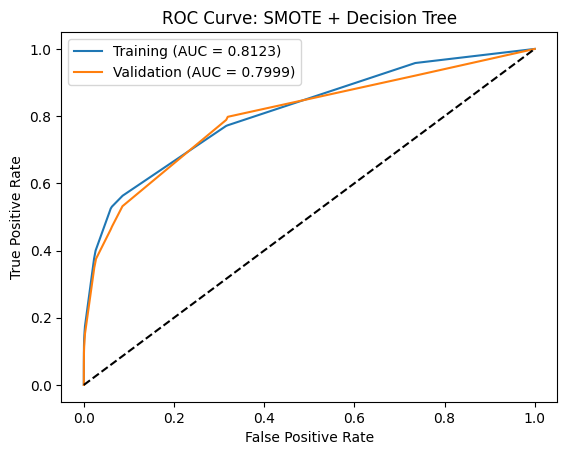

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.841973,0.974385,0.903353,0.723784,0.268486,0.391679,0.833205,0.783137,"[('cos_hour', np.float64(0.4320140140465478)),..."
1,SMOTE,Logistic Regression,Validation,0.962495,0.973990,0.968209,0.363007,0.280859,0.316693,0.939244,0.776358,"[('cos_hour', np.float64(0.4320140140465478)),..."
2,SMOTE,Decision Tree,Training,0.866650,0.973632,0.917032,0.791651,0.400756,0.532132,0.859057,0.812282,"[('Account Age Days', np.float64(0.52177279496..."
3,SMOTE,Decision Tree,Validation,0.967197,0.973225,0.970201,0.424717,0.374565,0.398067,0.943214,0.799896,"[('Account Age Days', np.float64(0.52177279496..."


In [319]:
pipeline_2 = Pipeline(steps=[
    ('classify_network', FunctionTransformer(classify_network_transformer))
])
X_encoded_train_2 = pipeline_2.fit_transform(X_encoded_train.copy())
X_encoded_valid_2 = pipeline_2.fit_transform(X_valid_encoded.copy())
compare_approaches(X_encoded_train_2, y_train, X_encoded_valid_2, y_valid)

In [320]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

# --- Custom Transformation Function ---
def custom_feature_engineering(X):
    X_out = X.copy()

    # Zmiana nazw kolumn: spacje na podkreślenia
    X_out.columns = [col.replace(' ', '_') for col in X_out.columns]

    # Flaga dla nowych kont (mniej niż 30 dni)
    X_out['isNewAccount'] = (X_out['Account_Age_Days'] < 30).astype(int)
    
    # Logarytmiczna transformacja kwoty transakcji (dodajemy 1, by uniknąć log(0))
    X_out['Amount_Log'] = np.log1p(X_out['Transaction_Amount'])
    
    # Stosunek kwoty transakcji do ilości (dodajemy 1, by uniknąć dzielenia przez zero)
    X_out['Amount_per_Quantity'] = X_out['Transaction_Amount'] / (X_out['Quantity'] + 1)
    
    # Flaga dla nietypowej godziny transakcji (przed 6 rano lub po 22)
    X_out['Unusual_Hour_Flag'] = ((X_out['Transaction_Hour'] < 6) | (X_out['Transaction_Hour'] > 22)).astype(int)

    # Flaga dla nowych kont i dużej transakcji (mniej niż 30 dni i kwota > 2000)
    X_out['New_Account_High_Transaction'] = ((X_out['Account_Age_Days'] < 30) & (X_out['Transaction_Amount'] > 2000)).astype(int)
    
    return X_out

# --- Scaler Transformer ---
class ScalerTransformer:
    def __init__(self):
        self.scaler = MinMaxScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[['Customer_Age']])
        return self
    
    def transform(self, X):
        X_out = X.copy()
        X_out['scaled_CustomerAge'] = self.scaler.transform(X[['Customer_Age']])
        return X_out

# --- Z-Score Transformer ---
class ZScoreTransformer:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
    
    def fit(self, X, y=None):
        self.mean_ = X['Transaction_Amount'].mean()
        self.std_ = X['Transaction_Amount'].std()
        return self
    
    def transform(self, X):
        X_out = X.copy()
        X_out['Amount_zscore'] = (X_out['Transaction_Amount'] - self.mean_) / (self.std_ + 1e-9)
        return X_out

# --- Quantile Threshold Transformer ---
class QuantileThresholdTransformer:
    def __init__(self, quantile=0.95):
        self.quantile = quantile
        self.threshold_ = None
    
    def fit(self, X, y=None):
        self.threshold_ = X['Transaction_Amount'].quantile(self.quantile)
        return self
    
    def transform(self, X):
        X_out = X.copy()
        X_out['High_Amount_Flag'] = (X_out['Transaction_Amount'] > self.threshold_).astype(int)
        return X_out


In [321]:
# --- Define the Pipeline ---
pipeline_3 = Pipeline(steps=[
    ('custom_features', FunctionTransformer(custom_feature_engineering)),
    ('scaler', ScalerTransformer()),
    ('zscore', ZScoreTransformer()),
    ('quantile_flag', QuantileThresholdTransformer())
])
pipeline_3.fit(X_encoded_train.copy())
X_encoded_train_3 = pipeline_3.transform(X_encoded_train.copy())
X_encoded_valid_3 = pipeline_3.transform(X_valid_encoded.copy())



--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91    685565
           1       0.76      0.42      0.54    171391

    accuracy                           0.86    856956
   macro avg       0.81      0.69      0.73    856956
weighted avg       0.85      0.86      0.84    856956

AUC-ROC Score: 0.8254

Top 7 Most Significant Features (out of 32):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- isNewAccount: 2.2630
- Unusual_Hour_Flag: 0.8718
- Amount_zscore: 0.5496
- device_tablet: 0.2179
- device_desktop: 0.2160
- device_mobile: 0.2066
- Amount_Log: 0.1956

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.39      0.41      0.40     15506

    accuracy                           0.94    309320
   macro avg      

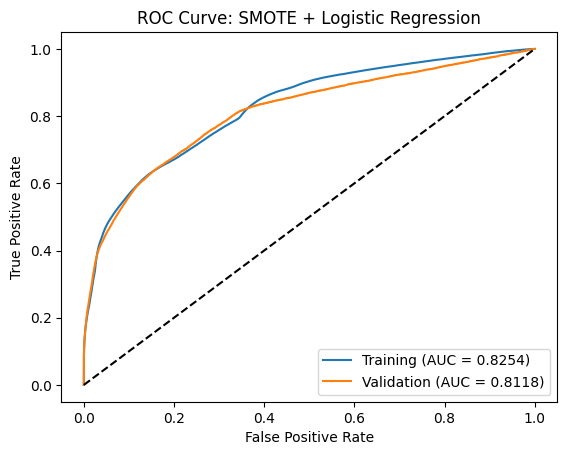


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94    685565
           1       0.87      0.64      0.74    171391

    accuracy                           0.91    856956
   macro avg       0.89      0.81      0.84    856956
weighted avg       0.91      0.91      0.90    856956

AUC-ROC Score: 0.8837

Top 7 Most Significant Features (out of 32):
Importance metric: Feature importance scores (higher = more influential in splits)
- Unusual_Hour_Flag: 0.5191
- isNewAccount: 0.3828
- Amount_zscore: 0.0434
- Transaction_Amount: 0.0408
- Transaction_Hour: 0.0102
- Amount_Log: 0.0037
- payment_credit_card: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    293814
           1       0.44      0.36      0.39     15506

    accuracy                           0.94    309320
   macro avg      

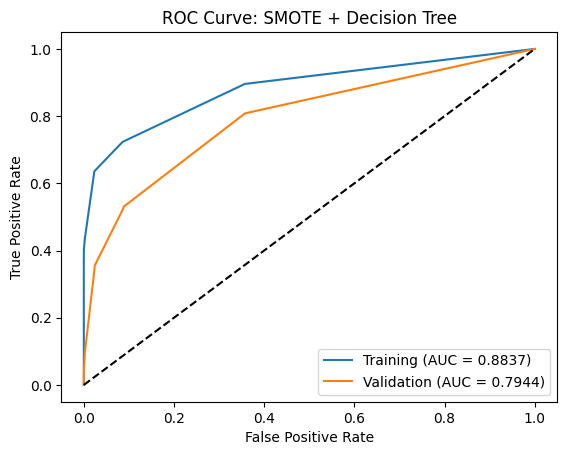

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.868627,0.966299,0.914864,0.755002,0.415419,0.535947,0.856123,0.825371,"[('isNewAccount', np.float64(2.262963259530891..."
1,SMOTE,Logistic Regression,Validation,0.968572,0.965965,0.967267,0.386390,0.406101,0.396000,0.937899,0.811787,"[('isNewAccount', np.float64(2.262963259530891..."
2,SMOTE,Decision Tree,Training,0.914746,0.976450,0.944591,0.870991,0.635979,0.735160,0.908356,0.883694,"[('Unusual_Hour_Flag', np.float64(0.5191194304..."
3,SMOTE,Decision Tree,Validation,0.966308,0.975753,0.971008,0.436125,0.355346,0.391613,0.944653,0.794367,"[('Unusual_Hour_Flag', np.float64(0.5191194304..."


In [322]:
compare_approaches(X_encoded_train_3, y_train, X_encoded_valid_3, y_valid)

In [323]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# --- Min-Max Scaler Transformer ---
class MinMaxScalerTransformer:
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[['Amount_per_Quantity', 'Amount_Log', 'Account_Age_Days', 'Quantity', 'Transaction_Hour']])
        return self

    def transform(self, X):
        X_out = X.copy()
        X_out[['Amount_per_Quantity', 'Amount_Log', 'Account_Age_Days', 'Quantity','Transaction_Hour']] = self.scaler.transform(
            X[['Amount_per_Quantity', 'Amount_Log', 'Account_Age_Days', 'Quantity','Transaction_Hour']]
        )
        return X_out

# --- Column Dropper Transformer ---
class ColumnDropperTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_out = X.copy()
        columns_to_drop = [
            'Transaction_Amount', 'Customer_Age',
            'octet1', 'octet2', 'octet3','octet4']
        X_out = X_out.drop(columns=columns_to_drop)
        return X_out

# --- Define the Pipeline ---
pipeline_4 = Pipeline(steps=[
    ('minmax_scaler', MinMaxScalerTransformer()),
    ('column_dropper', ColumnDropperTransformer())
])


In [324]:
pipeline_4.fit(X_encoded_train_3.copy())
X_encoded_train_4 = pipeline_4.transform(X_encoded_train_3.copy())
X_encoded_valid_4 = pipeline_4.transform(X_encoded_valid_3.copy())
X_encoded_train_4.columns

/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Index(['Quantity', 'Account_Age_Days', 'Transaction_Hour', 'payment_PayPal',
       'payment_bank_transfer', 'payment_credit_card', 'payment_debit_card',
       'product_clothing', 'product_electronics', 'product_health_&_beauty',
       'product_home_&_garden', 'product_toys_&_games', 'device_desktop',
       'device_mobile', 'device_tablet', 'sin_hour', 'cos_hour',
       'addressSimilarity', 'isNewAccount', 'Amount_Log',
       'Amount_per_Quantity', 'Unusual_Hour_Flag',
       'New_Account_High_Transaction', 'scaled_CustomerAge', 'Amount_zscore',
       'High_Amount_Flag'],
      dtype='object')


--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91    685565
           1       0.75      0.40      0.52    171391

    accuracy                           0.85    856956
   macro avg       0.81      0.68      0.72    856956
weighted avg       0.84      0.85      0.84    856956

AUC-ROC Score: 0.8105

Top 7 Most Significant Features (out of 26):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- isNewAccount: 2.1056
- Transaction_Hour: 1.0517
- Amount_Log: 0.9961
- Unusual_Hour_Flag: 0.7748
- Amount_zscore: 0.6992
- device_desktop: 0.2939
- device_tablet: 0.2925

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.39      0.40      0.40     15506

    accuracy                           0.94    309320
   macro avg   

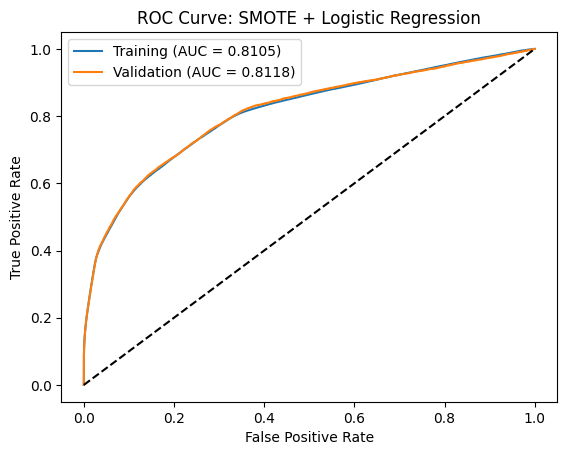


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92    685565
           1       0.80      0.39      0.52    171391

    accuracy                           0.86    856956
   macro avg       0.83      0.68      0.72    856956
weighted avg       0.85      0.86      0.84    856956

AUC-ROC Score: 0.8024

Top 7 Most Significant Features (out of 26):
Importance metric: Feature importance scores (higher = more influential in splits)
- isNewAccount: 0.5146
- Amount_zscore: 0.2695
- Transaction_Hour: 0.1505
- cos_hour: 0.0569
- Quantity: 0.0057
- Account_Age_Days: 0.0028
- product_home_&_garden: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    293814
           1       0.44      0.36      0.40     15506

    accuracy                           0.94    309320
   macro avg       0.70      

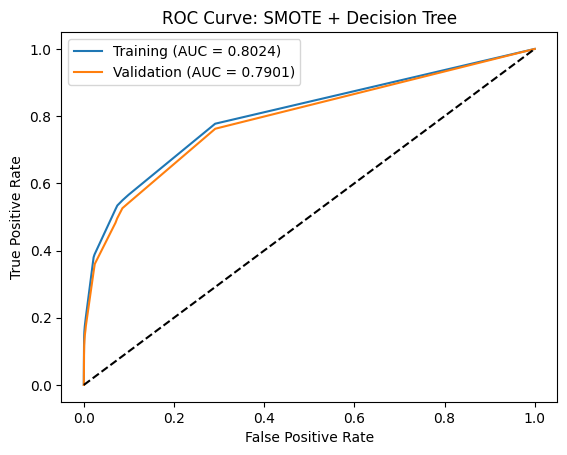

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.865709,0.966725,0.913433,0.750402,0.400155,0.521968,0.853411,0.810457,"[('isNewAccount', np.float64(2.105636861144548..."
1,SMOTE,Logistic Regression,Validation,0.968497,0.966513,0.967504,0.389185,0.404295,0.396596,0.938329,0.811823,"[('isNewAccount', np.float64(2.105636861144548..."
2,SMOTE,Decision Tree,Training,0.864534,0.976282,0.917016,0.803566,0.388095,0.523404,0.858645,0.802406,"[('isNewAccount', np.float64(0.514560594109363..."
3,SMOTE,Decision Tree,Validation,0.966546,0.975672,0.971087,0.438580,0.360119,0.395495,0.944814,0.790068,"[('isNewAccount', np.float64(0.514560594109363..."


In [325]:
compare_approaches(X_encoded_train_4, y_train, X_encoded_valid_4, y_valid)

In [326]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# --- Column Dropper Transformer ---
class ColumnDropperTransformer2:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_out = X.copy()
        columns_to_drop = ['Quantity', 'payment_PayPal',
       'payment_bank_transfer', 'payment_credit_card', 'payment_debit_card',
       'product_clothing', 'product_electronics', 'product_health_&_beauty',
       'product_home_&_garden', 'product_toys_&_games', 'device_desktop',
       'device_mobile', 'device_tablet', 'Amount_per_Quantity'
            ]
        X_out = X_out.drop(columns=columns_to_drop)
        return X_out

# --- Define the Pipeline ---
pipeline_5 = Pipeline(steps=[
    ('column_dropper', ColumnDropperTransformer2())
])


In [327]:
pipeline_5.fit(X_encoded_train_4.copy())
X_encoded_train_5 = pipeline_5.transform(X_encoded_train_4.copy())
X_encoded_valid_5 = pipeline_5.transform(X_encoded_valid_4.copy())

/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91    685565
           1       0.75      0.40      0.52    171391

    accuracy                           0.85    856956
   macro avg       0.81      0.68      0.72    856956
weighted avg       0.84      0.85      0.84    856956

AUC-ROC Score: 0.8100

Top 7 Most Significant Features (out of 12):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- isNewAccount: 2.1092
- Amount_Log: 1.1000
- Transaction_Hour: 0.9436
- Unusual_Hour_Flag: 0.7924
- Amount_zscore: 0.7240
- Account_Age_Days: 0.1380
- scaled_CustomerAge: 0.1136

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.39      0.41      0.40     15506

    accuracy                           0.94    309320
   macro

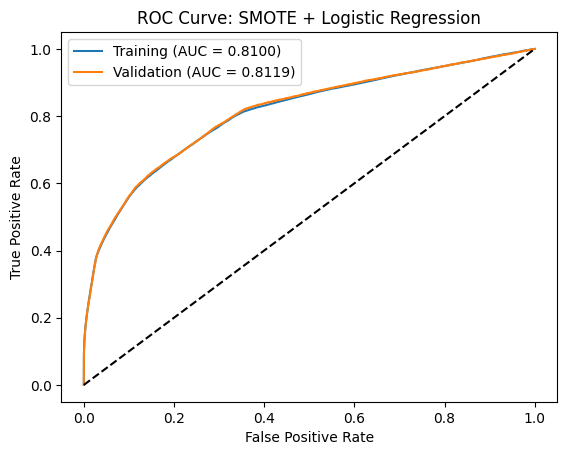


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91    685565
           1       0.80      0.36      0.49    171391

    accuracy                           0.85    856956
   macro avg       0.83      0.67      0.70    856956
weighted avg       0.85      0.85      0.83    856956

AUC-ROC Score: 0.8024

Top 7 Most Significant Features (out of 12):
Importance metric: Feature importance scores (higher = more influential in splits)
- Account_Age_Days: 0.5364
- Amount_zscore: 0.2961
- Transaction_Hour: 0.1533
- Amount_Log: 0.0142
- High_Amount_Flag: 0.0000
- scaled_CustomerAge: 0.0000
- New_Account_High_Transaction: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    293814
           1       0.45      0.34      0.39     15506

    accuracy                           0.95    309320
   mac

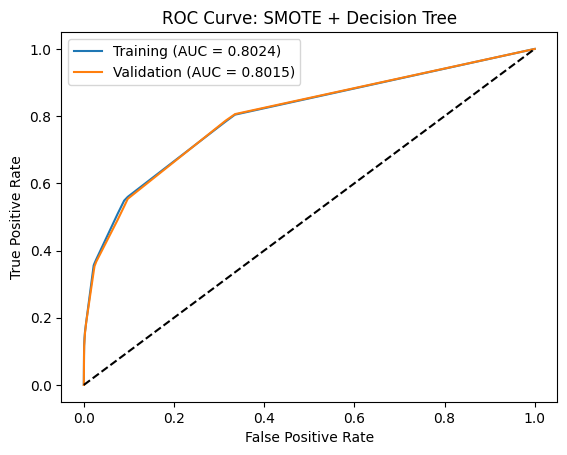

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.865893,0.966681,0.913515,0.750611,0.401130,0.522847,0.853571,0.810011,"[('isNewAccount', np.float64(2.109168774071046..."
1,SMOTE,Logistic Regression,Validation,0.968562,0.966360,0.967459,0.388896,0.405649,0.397096,0.938252,0.811930,"[('isNewAccount', np.float64(2.109168774071046..."
2,SMOTE,Decision Tree,Training,0.858553,0.978211,0.914484,0.803040,0.355357,0.492691,0.853640,0.802403,"[('Account_Age_Days', np.float64(0.53638892058..."
3,SMOTE,Decision Tree,Validation,0.965701,0.977622,0.971625,0.446502,0.342061,0.387365,0.945762,0.801469,"[('Account_Age_Days', np.float64(0.53638892058..."


In [328]:
compare_approaches(X_encoded_train_5, y_train, X_encoded_valid_5, y_valid)

In [329]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Your evaluate_brier_score function
def evaluate_brier_score(X_train, y_train, X_valid, y_valid, use_undersampling=False, random_state=42):
    """
    Evaluates Brier Score Loss for a Decision Tree model before and after calibration.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_valid: Validation features
    - y_valid: Validation labels
    - use_undersampling: Boolean, whether to apply RandomUnderSampler
    - random_state: Random seed for reproducibility
    
    Returns:
    - Dictionary with Brier scores
    """
    model = DecisionTreeClassifier(random_state=random_state, max_depth=4)
    
    if use_undersampling:
        rus = RandomUnderSampler(sampling_strategy=1.0, random_state=777)
        X_train_final, y_train_final = rus.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train
    
    model.fit(X_train_final, y_train_final)
    y_proba_before = model.predict_proba(X_valid)[:, 1]
    brier_before = brier_score_loss(y_valid, y_proba_before)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    calibrated_sigmoid = CalibratedClassifierCV(model, method='sigmoid', cv=kf)
    calibrated_sigmoid.fit(X_train_final, y_train_final)
    y_proba_sigmoid = calibrated_sigmoid.predict_proba(X_valid)[:, 1]
    brier_sigmoid = brier_score_loss(y_valid, y_proba_sigmoid)
    
    calibrated_isotonic = CalibratedClassifierCV(model, method='isotonic', cv=5)
    calibrated_isotonic.fit(X_train_final, y_train_final)
    y_proba_isotonic = calibrated_isotonic.predict_proba(X_valid)[:, 1]
    brier_isotonic = brier_score_loss(y_valid, y_proba_isotonic)
    
    results = {
        'before_calibration': brier_before,
        'sigmoid_calibration': brier_sigmoid,
        'isotonic_calibration': brier_isotonic
    }
    
    print(f"Brier Score Loss przed kalibracją: {brier_before:.4f}")
    print(f"Brier Score Loss po kalibracji (sigmoid): {brier_sigmoid:.4f}")
    print(f"Brier Score Loss po kalibracji (isotonic): {brier_isotonic:.4f}")
    
    return results

In [330]:
# Apply RandomUnderSampler as in your original code
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=777)
X_train_rus, y_train_rus = rus.fit_resample(X_encoded_train_5, y_train)

# Use evaluate_brier_score with the undersampled data
results = evaluate_brier_score(
    X_train=X_train_rus,  # Pass the already undersampled data
    y_train=y_train_rus,
    X_valid=X_encoded_valid_5,
    y_valid=y_valid,
    use_undersampling=False  # No additional undersampling since it's already done
)

Brier Score Loss przed kalibracją: 0.1547
Brier Score Loss po kalibracji (sigmoid): 0.1595
Brier Score Loss po kalibracji (isotonic): 0.1547



--- Report before Calibration ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    293814
           1       0.22      0.59      0.32     15506

    accuracy                           0.87    309320
   macro avg       0.60      0.74      0.63    309320
weighted avg       0.94      0.87      0.90    309320


--- Report after Calibration (sigmoid) ---
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    293814
           1       0.12      0.80      0.20     15506

    accuracy                           0.68    309320
   macro avg       0.55      0.74      0.50    309320
weighted avg       0.94      0.68      0.77    309320

AUC-ROC before calibration: 0.8112
AUC-ROC after calibration: 0.8154


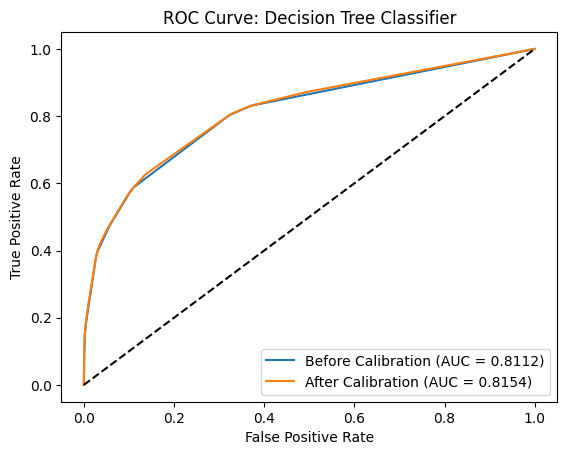

Brier Score Loss before calibration: 0.1547
Brier Score Loss after calibration: 0.1595


In [331]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# 1. Przetwarzanie danych z Random Under Sampler
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=777)
X_train_rus, y_train_rus = rus.fit_resample(X_encoded_train_4, y_train)

# 2. Model drzewa decyzyjnego
model = DecisionTreeClassifier(random_state=42, max_depth=4)

# 3. Trenowanie modelu przed kalibracją
model.fit(X_train_rus, y_train_rus)

# 4. Przewidywanie prawdopodobieństw przed kalibracją
y_proba_before = model.predict_proba(X_encoded_valid_4)[:, 1]
brier_before = brier_score_loss(y_valid, y_proba_before)

# Raport klasyfikacji przed kalibracją
y_pred_before = model.predict(X_encoded_valid_4)
print("\n--- Report before Calibration ---")
print(classification_report(y_valid, y_pred_before))

# 5. Kalibracja metodą sigmoid
kf = KFold(n_splits=5, shuffle=True, random_state=42)
calibrated_sigmoid = CalibratedClassifierCV(model, method='sigmoid', cv=kf)
calibrated_sigmoid.fit(X_train_rus, y_train_rus)
y_proba_sigmoid = calibrated_sigmoid.predict_proba(X_encoded_valid_4)[:, 1]
brier_sigmoid = brier_score_loss(y_valid, y_proba_sigmoid)

# Raport klasyfikacji po kalibracji
y_pred_sigmoid = calibrated_sigmoid.predict(X_encoded_valid_4)
print("\n--- Report after Calibration (sigmoid) ---")
print(classification_report(y_valid, y_pred_sigmoid))

# 6. AUC-ROC przed i po kalibracji
auc_before = roc_auc_score(y_valid, y_proba_before)
auc_after = roc_auc_score(y_valid, y_proba_sigmoid)
print(f"AUC-ROC before calibration: {auc_before:.4f}")
print(f"AUC-ROC after calibration: {auc_after:.4f}")

# 7. Wizualizacja ROC Curve
fpr_before, tpr_before, _ = roc_curve(y_valid, y_proba_before)
fpr_after, tpr_after, _ = roc_curve(y_valid, y_proba_sigmoid)

plt.plot(fpr_before, tpr_before, label=f'Before Calibration (AUC = {auc_before:.4f})')
plt.plot(fpr_after, tpr_after, label=f'After Calibration (AUC = {auc_after:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree Classifier')
plt.legend(loc='best')
plt.show()

# 8. Drukowanie wyników Brier Score
print(f"Brier Score Loss before calibration: {brier_before:.4f}")
print(f"Brier Score Loss after calibration: {brier_sigmoid:.4f}")


=== Wyniki dla danych bez RandomUnderSampler ===
Brier Score Loss przed kalibracją: 0.0382
Brier Score Loss po kalibracji (sigmoid): 0.0388
Brier Score Loss po kalibracji (isotonic): 0.0382

=== Wyniki dla danych z RandomUnderSampler ===
Brier Score Loss przed kalibracją: 0.1547
Brier Score Loss po kalibracji (sigmoid): 0.1595
Brier Score Loss po kalibracji (isotonic): 0.1544

--- Report before Calibration (RUS) ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    293814
           1       0.22      0.59      0.32     15506

    accuracy                           0.87    309320
   macro avg       0.60      0.74      0.63    309320
weighted avg       0.94      0.87      0.90    309320


--- Report after Calibration (sigmoid, RUS) ---
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    293814
           1       0.12      0.80      0.20     15506

    accuracy                           0

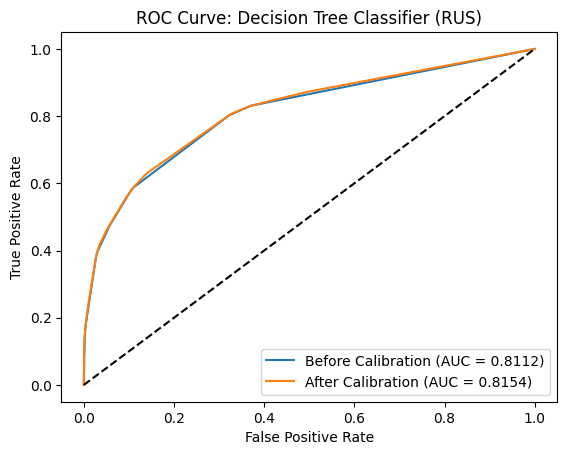

In [332]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, classification_report, roc_auc_score
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Funkcja do trenowania i kalibracji modelu
def train_and_evaluate(X_train, y_train, X_valid, y_valid, cv, method='sigmoid'):
    # Nowa instancja modelu dla każdego przypadku
    model = DecisionTreeClassifier(random_state=42, max_depth=4)  # Dodano max_depth
    model.fit(X_train, y_train)
    y_proba_before = model.predict_proba(X_valid)[:, 1]
    brier_before = brier_score_loss(y_valid, y_proba_before)
    y_pred_before = model.predict(X_valid)

    # Kalibracja
    calibrated = CalibratedClassifierCV(model, method=method, cv=cv)
    calibrated.fit(X_train, y_train)
    y_proba_calibrated = calibrated.predict_proba(X_valid)[:, 1]
    brier_calibrated = brier_score_loss(y_valid, y_proba_calibrated)
    y_pred_calibrated = calibrated.predict(X_valid)

    return {
        'brier_before': brier_before,
        'brier_calibrated': brier_calibrated,
        'y_proba_before': y_proba_before,
        'y_pred_before': y_pred_before,
        'y_proba_calibrated': y_proba_calibrated,
        'y_pred_calibrated': y_pred_calibrated,
        'calibrated_model': calibrated
    }

# Definicja walidacji krzyżowej
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. Przygotowanie danych z RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=777)
X_train_rus, y_train_rus = rus.fit_resample(X_encoded_train_4, y_train)

# 2. Trenowanie i kalibracja
results_sigmoid = train_and_evaluate(X_encoded_train_4, y_train, X_encoded_valid_4, y_valid, kf, method='sigmoid')
results_sigmoid_rus = train_and_evaluate(X_train_rus, y_train_rus, X_encoded_valid_4, y_valid, kf, method='sigmoid')
results_isotonic = train_and_evaluate(X_encoded_train_4, y_train, X_encoded_valid_4, y_valid, kf, method='isotonic')
results_isotonic_rus = train_and_evaluate(X_train_rus, y_train_rus, X_encoded_valid_4, y_valid, kf, method='isotonic')

# 3. Wyniki dla danych bez RUS
print("=== Wyniki dla danych bez RandomUnderSampler ===")
print(f"Brier Score Loss przed kalibracją: {results_sigmoid['brier_before']:.4f}")
print(f"Brier Score Loss po kalibracji (sigmoid): {results_sigmoid['brier_calibrated']:.4f}")
print(f"Brier Score Loss po kalibracji (isotonic): {results_isotonic['brier_calibrated']:.4f}")

# 4. Wyniki dla danych z RUS
print("\n=== Wyniki dla danych z RandomUnderSampler ===")
print(f"Brier Score Loss przed kalibracją: {results_sigmoid_rus['brier_before']:.4f}")
print(f"Brier Score Loss po kalibracji (sigmoid): {results_sigmoid_rus['brier_calibrated']:.4f}")
print(f"Brier Score Loss po kalibracji (isotonic): {results_isotonic_rus['brier_calibrated']:.4f}")

# 5. Raport klasyfikacji dla danych z RUS (sigmoid)
print("\n--- Report before Calibration (RUS) ---")
print(classification_report(y_valid, results_sigmoid_rus['y_pred_before']))
print("\n--- Report after Calibration (sigmoid, RUS) ---")
print(classification_report(y_valid, results_sigmoid_rus['y_pred_calibrated']))

# 6. AUC-ROC i wykres ROC dla danych z RUS
auc_before = roc_auc_score(y_valid, results_sigmoid_rus['y_proba_before'])
auc_after = roc_auc_score(y_valid, results_sigmoid_rus['y_proba_calibrated'])
print(f"AUC-ROC before calibration: {auc_before:.4f}")
print(f"AUC-ROC after calibration: {auc_after:.4f}")

fpr_before, tpr_before, _ = roc_curve(y_valid, results_sigmoid_rus['y_proba_before'])
fpr_after, tpr_after, _ = roc_curve(y_valid, results_sigmoid_rus['y_proba_calibrated'])

plt.plot(fpr_before, tpr_before, label=f'Before Calibration (AUC = {auc_before:.4f})')
plt.plot(fpr_after, tpr_after, label=f'After Calibration (AUC = {auc_after:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree Classifier (RUS)')
plt.legend(loc='best')
plt.show()

Nie robimy kalibracji bo szkodzi nam.


--- SMOTE + Logistic Regression (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91    685565
           1       0.75      0.40      0.52    171391

    accuracy                           0.85    856956
   macro avg       0.81      0.68      0.72    856956
weighted avg       0.84      0.85      0.84    856956

AUC-ROC Score: 0.8105

Top 7 Most Significant Features (out of 26):
Importance metric: Absolute coefficient values (larger = more impact on prediction)
- isNewAccount: 2.1056
- Transaction_Hour: 1.0517
- Amount_Log: 0.9961
- Unusual_Hour_Flag: 0.7748
- Amount_zscore: 0.6992
- device_desktop: 0.2939
- device_tablet: 0.2925

--- SMOTE + Logistic Regression (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    293814
           1       0.39      0.40      0.40     15506

    accuracy                           0.94    309320
   macro avg   

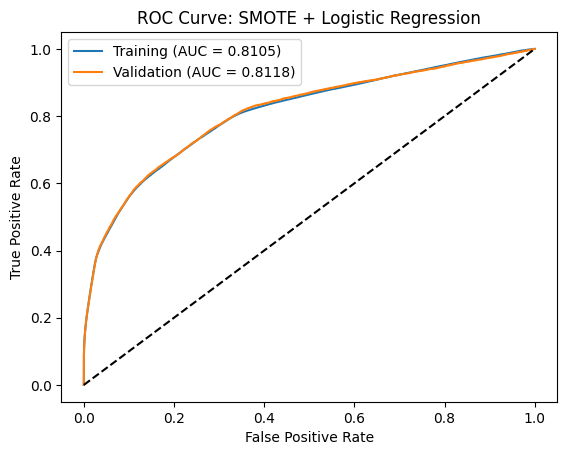


--- SMOTE + Decision Tree (Training) ---
Results:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92    685565
           1       0.80      0.39      0.52    171391

    accuracy                           0.86    856956
   macro avg       0.83      0.68      0.72    856956
weighted avg       0.85      0.86      0.84    856956

AUC-ROC Score: 0.8024

Top 7 Most Significant Features (out of 26):
Importance metric: Feature importance scores (higher = more influential in splits)
- isNewAccount: 0.5146
- Amount_zscore: 0.2695
- Transaction_Hour: 0.1505
- cos_hour: 0.0569
- Quantity: 0.0057
- Account_Age_Days: 0.0028
- product_home_&_garden: 0.0000

--- SMOTE + Decision Tree (Validation) ---
Results:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97    293814
           1       0.44      0.36      0.40     15506

    accuracy                           0.94    309320
   macro avg       0.70      

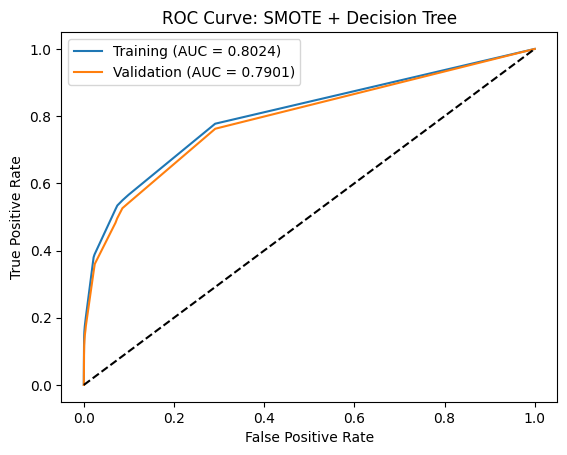

,Sampler,Classifier,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Accuracy,AUC-ROC,Top_Features
0,SMOTE,Logistic Regression,Training,0.865709,0.966725,0.913433,0.750402,0.400155,0.521968,0.853411,0.810457,"[('isNewAccount', np.float64(2.105636861144548..."
1,SMOTE,Logistic Regression,Validation,0.968497,0.966513,0.967504,0.389185,0.404295,0.396596,0.938329,0.811823,"[('isNewAccount', np.float64(2.105636861144548..."
2,SMOTE,Decision Tree,Training,0.864534,0.976282,0.917016,0.803566,0.388095,0.523404,0.858645,0.802406,"[('isNewAccount', np.float64(0.514560594109363..."
3,SMOTE,Decision Tree,Validation,0.966546,0.975672,0.971087,0.438580,0.360119,0.395495,0.944814,0.790068,"[('isNewAccount', np.float64(0.514560594109363..."


In [333]:
compare_approaches(X_encoded_train_4, y_train, X_encoded_valid_4, y_valid)

In [334]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import time

# Configurable parameter grids for each speed setting
def get_param_grids(speed='fast'):
    if speed == 'fast':  # ~1 minute total
        return {
            'DecisionTree': {'max_depth': [3, 5], 'class_weight': ['balanced'], 'criterion': ['gini']},
            'LogisticRegression': {'C': [0.1, 1.0], 'class_weight': ['balanced'], 'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': [100]},
            'RandomForest': {'n_estimators': [50], 'max_depth': [5], 'class_weight': ['balanced']},
            'XGBoost': {'n_estimators': [50], 'max_depth': [3], 'learning_rate': [0.1], 'scale_pos_weight': [19]},
            'LightGBM': {'n_estimators': [50], 'max_depth': [3], 'learning_rate': [0.1], 'is_unbalance': [True]},
            'BalancedRandomForest': {'n_estimators': [50], 'max_depth': [5]},
        }
    elif speed == 'medium':  # ~5 minutes total
        return {
            'DecisionTree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5], 'class_weight': ['balanced', {0: 1, 1: 19}], 'criterion': ['gini', 'entropy']},
            'LogisticRegression': {'C': [0.01, 0.1, 1.0], 'class_weight': ['balanced', {0: 1, 1: 19}], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': [200]},
            'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10], 'class_weight': ['balanced', {0: 1, 1: 19}]},
            'XGBoost': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1], 'scale_pos_weight': [19]},
            'LightGBM': {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1], 'is_unbalance': [True]},
            'BalancedRandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
        }
    elif speed == 'slow':  # ~10 minutes total
        return {
            'DecisionTree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2], 'class_weight': [{0: 1, 1: 19}, 'balanced', None], 'criterion': ['gini', 'entropy']},
            'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1.0, 10.0], 'class_weight': [{0: 1, 1: 19}, 'balanced', None], 'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'max_iter': [500]},
            'RandomForest': {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5], 'class_weight': [{0: 1, 1: 19}, 'balanced']},
            'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'scale_pos_weight': [19]},
            'LightGBM': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'is_unbalance': [True]},
            'BalancedRandomForest': {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]},
        }
    else:
        raise ValueError("Speed must be 'fast', 'medium', or 'slow'")

# Classifiers
classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
    'BalancedRandomForest': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
}

# Main function to run grid search with custom datasets and method selection
def run_grid_search(X_train, y_train, X_valid, y_valid, speed='fast', method='all'):
    param_grids = get_param_grids(speed)
    results = []
    
    # If method is 'all', use all classifiers; otherwise, use only the specified ones
    if method == 'all':
        selected_classifiers = classifiers
    else:
        if isinstance(method, str):
            method = [method]  # Convert single string to list
        if not all(m in classifiers for m in method):
            raise ValueError(f"Invalid method(s). Choose from: {list(classifiers.keys())}")
        selected_classifiers = {name: clf for name, clf in classifiers.items() if name in method}
    
    for name, clf in selected_classifiers.items():
        start_time = time.time()
        print(f"\nRunning GridSearchCV for {name} ({speed})...")
        
        grid_search = GridSearchCV(
            clf,
            param_grids[name],
            cv=3,
            scoring='f1',  # Focus on positive class due to 5% imbalance
            n_jobs=-1
        )
        
        # Fit on training data
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Evaluate on training set
        y_train_pred = best_model.predict(X_train)
        train_report = classification_report(y_train, y_train_pred, output_dict=True)
        
        # Evaluate on validation set
        y_valid_pred = best_model.predict(X_valid)
        valid_report = classification_report(y_valid, y_valid_pred, output_dict=True)
        
        # Store results for table
        runtime = time.time() - start_time
        results.append({
            'Classifier': name,
            'Best_Params': str(grid_search.best_params_),
            'Train_F1_Positive': train_report['1']['f1-score'],
            'Train_Recall_Positive': train_report['1']['recall'],
            'Train_Precision_Positive': train_report['1']['precision'],
            'Valid_F1_Positive': valid_report['1']['f1-score'],
            'Valid_Recall_Positive': valid_report['1']['recall'],
            'Valid_Precision_Positive': valid_report['1']['precision'],
            'Runtime (s)': runtime
        })
        
        # Print detailed output
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best F1 score (training): {grid_search.best_score_:.4f}")
        print(f"Training Classification Report:\n{classification_report(y_train, y_train_pred)}")
        print(f"Validation Classification Report:\n{classification_report(y_valid, y_valid_pred)}")
        print(f"Runtime: {runtime:.2f} seconds")
    
    # Create and display results table
    results_df = pd.DataFrame(results)
    print("\nResults Table:")
    print(results_df.to_string(index=False))
    
    return results_df

In [335]:
smote = SMOTE(sampling_strategy=1.0, random_state=777)
X_selected_train, y_selected_train = smote.fit_resample(X_encoded_train_5, y_train)
X_selected_valid=X_encoded_valid_5
y_selected_valid=y_valid


In [336]:
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='DecisionTree'
)


Running GridSearchCV for DecisionTree (fast)...
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3}
Best F1 score (training): 0.7511
Training Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72    685565
           1       0.71      0.80      0.75    685565

    accuracy                           0.74   1371130
   macro avg       0.74      0.74      0.73   1371130
weighted avg       0.74      0.74      0.73   1371130

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    293814
           1       0.11      0.80      0.20     15506

    accuracy                           0.68    309320
   macro avg       0.55      0.74      0.50    309320
weighted avg       0.94      0.68      0.77    309320

Runtime: 10.70 seconds

Results Table:
  Classifier                                                       Best_Para

In [337]:
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='LogisticRegression'
)


Running GridSearchCV for LogisticRegression (fast)...
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score (training): 0.7210
Training Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75    685565
           1       0.77      0.67      0.72    685565

    accuracy                           0.74   1371130
   macro avg       0.74      0.74      0.74   1371130
weighted avg       0.74      0.74      0.74   1371130

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88    293814
           1       0.15      0.68      0.25     15506

    accuracy                           0.80    309320
   macro avg       0.57      0.74      0.57    309320
weighted avg       0.94      0.80      0.85    309320

Runtime: 4.82 seconds

Results Table:
        Classifier                           

In [338]:
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='RandomForest'
)


Running GridSearchCV for RandomForest (fast)...
Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 50}
Best F1 score (training): 0.7123
Training Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77    685565
           1       0.81      0.63      0.71    685565

    accuracy                           0.74   1371130
   macro avg       0.76      0.74      0.74   1371130
weighted avg       0.76      0.74      0.74   1371130

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    293814
           1       0.18      0.63      0.29     15506

    accuracy                           0.84    309320
   macro avg       0.58      0.74      0.60    309320
weighted avg       0.94      0.84      0.88    309320

Runtime: 35.32 seconds

Results Table:
  Classifier                                                      Best_Params

In [339]:
# Run with your datasets
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='XGBoost'
)


Running GridSearchCV for XGBoost (fast)...


/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/lear

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 19}
Best F1 score (training): 0.6667
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    685565
           1       0.50      1.00      0.67    685565

    accuracy                           0.50   1371130
   macro avg       0.75      0.50      0.33   1371130
weighted avg       0.75      0.50      0.33   1371130

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    293814
           1       0.05      1.00      0.10     15506

    accuracy                           0.05    309320
   macro avg       0.03      0.50      0.05    309320
weighted avg       0.00      0.05      0.00    309320

Runtime: 5.17 seconds

Results Table:
Classifier                                                                        Best_Params  Train_F1_Posit

/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adamryski/4sem/ml/kochaML/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [340]:
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='LightGBM'
)


Running GridSearchCV for LightGBM (fast)...
[LightGBM] [Info] Number of positive: 457044, number of negative: 457043
[LightGBM] [Info] Number of positive: 457043, number of negative: 457044
[LightGBM] [Info] Number of positive: 457043, number of negative: 457043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 914087, number of used features: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 914087, number of used features: 12
[LightGBM] [Info] [binary:Bo

In [341]:
results_df = run_grid_search(
    X_train=X_selected_train,
    y_train=y_selected_train,
    X_valid=X_selected_valid,
    y_valid=y_selected_valid,
    speed='fast',
    method='BalancedRandomForest'
)


Running GridSearchCV for BalancedRandomForest (fast)...
Best parameters: {'max_depth': 5, 'n_estimators': 50}
Best F1 score (training): 0.7481
Training Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73    685565
           1       0.72      0.78      0.75    685565

    accuracy                           0.74   1371130
   macro avg       0.74      0.74      0.74   1371130
weighted avg       0.74      0.74      0.74   1371130

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    293814
           1       0.12      0.77      0.21     15506

    accuracy                           0.71    309320
   macro avg       0.55      0.74      0.51    309320
weighted avg       0.94      0.71      0.79    309320

Runtime: 91.52 seconds

Results Table:
          Classifier                          Best_Params  Train_F1_Positive  Train_Recall_Positi

Wybraliśmy DecisionTree, BalancedRandomForest i LightGBM, ponieważ osiągają precyzję dla klasy 0 na poziomie 98% na zbiorze walidacyjnym, spełniając twój cel, a jednocześnie oferują wysokie lub możliwe do poprawy wartości recall dla klasy 1. DecisionTree zapewnia recall dla klasy 1 na poziomie 79,91%, prawie osiągając twój cel 80%, a BalancedRandomForest jest blisko z 77,31%, co sugeruje, że drobne dostrojenie może je przewyższyć. LightGBM z recall dla klasy 1 na poziomie 68,63% jest niższy, ale obiecujący, ponieważ jego precyzja dla klasy 0 wynosi 98%, a recall może wzrosnąć dzięki głębszej optymalizacji.

In [342]:
results_df = run_grid_search(
    X_train=X_encoded_train_4,
    y_train=y_train,
    X_valid=X_encoded_valid_4,
    y_valid=y_valid,
    speed='medium',
    method='DecisionTree'
)


Running GridSearchCV for DecisionTree (medium)...
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Best F1 score (training): 0.2354
Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87    685565
           1       0.15      0.72      0.24     36181

    accuracy                           0.77    721746
   macro avg       0.56      0.75      0.55    721746
weighted avg       0.94      0.77      0.84    721746

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87    293814
           1       0.14      0.70      0.24     15506

    accuracy                           0.77    309320
   macro avg       0.56      0.74      0.55    309320
weighted avg       0.94      0.77      0.83    309320

Runtime: 78.54 seconds

Results Table:
  Classifier                                  

In [343]:
results_df = run_grid_search(
    X_train=X_encoded_train_4,
    y_train=y_train,
    X_valid=X_encoded_valid_4,
    y_valid=y_valid,
    speed='medium',
    method='BalancedRandomForest'
)


Running GridSearchCV for BalancedRandomForest (medium)...
Best parameters: {'max_depth': 10, 'n_estimators': 50}
Best F1 score (training): 0.2441
Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    685565
           1       0.15      0.72      0.25     36181

    accuracy                           0.78    721746
   macro avg       0.57      0.75      0.56    721746
weighted avg       0.94      0.78      0.84    721746

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87    293814
           1       0.15      0.70      0.25     15506

    accuracy                           0.78    309320
   macro avg       0.56      0.75      0.56    309320
weighted avg       0.94      0.78      0.84    309320

Runtime: 54.09 seconds

Results Table:
          Classifier                           Best_Params  Train_F1_Positive  Train_Recall_Po

In [344]:
results_df = run_grid_search(
    X_train=X_encoded_train_4,
    y_train=y_train,
    X_valid=X_encoded_valid_4,
    y_valid=y_valid,
    speed='medium',
    method='LightGBM'
)


Running GridSearchCV for LightGBM (medium)...
[LightGBM] [Info] Number of positive: 24121, number of negative: 457043
[LightGBM] [Info] Number of positive: 24121, number of negative: 457043
[LightGBM] [Info] Number of positive: 24121, number of negative: 457043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 481164, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050131 -> initscore=-2.941695
[LightGBM] [Info] Start training from score -2.941695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train 

In [345]:
results_df = run_grid_search(
    X_train=X_encoded_train_4,
    y_train=y_train,
    X_valid=X_encoded_valid_4,
    y_valid=y_valid,
    speed='slow',
    method='DecisionTree'
)


Running GridSearchCV for DecisionTree (slow)...
Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best F1 score (training): 0.2648
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    685565
           1       0.83      0.51      0.63     36181

    accuracy                           0.97    721746
   macro avg       0.90      0.75      0.81    721746
weighted avg       0.97      0.97      0.97    721746

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    293814
           1       0.33      0.22      0.26     15506

    accuracy                           0.94    309320
   macro avg       0.65      0.60      0.62    309320
weighted avg       0.93      0.94      0.93    309320

Runtime: 793.84 seconds

Results Table:
  Classifier                  

In [346]:
results_df = run_grid_search(
    X_train=X_encoded_train_4,
    y_train=y_train,
    X_valid=X_encoded_valid_4,
    y_valid=y_valid,
    speed='slow',
    method='DecisionTree'
)


Running GridSearchCV for DecisionTree (slow)...
Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best F1 score (training): 0.2648
Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    685565
           1       0.83      0.51      0.63     36181

    accuracy                           0.97    721746
   macro avg       0.90      0.75      0.81    721746
weighted avg       0.97      0.97      0.97    721746

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    293814
           1       0.33      0.22      0.26     15506

    accuracy                           0.94    309320
   macro avg       0.65      0.60      0.62    309320
weighted avg       0.93      0.94      0.93    309320

Runtime: 679.68 seconds

Results Table:
  Classifier                  